<a href="https://colab.research.google.com/github/AlessandrodeAlmeida2/RabulaBenchmark/blob/main/Paper2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 7.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error
from pingouin import intraclass_corr
import scipy.stats as st


#### Projeto Integrador IV
Notebook modificado do original usado no paper para fins de desenvolver o Projeto Integrador IV da Univesp.

Os objetivos são os seguintes:
1. Melhorar a UX do dashboard (scoreboard.py) para que as matérias de direito sejam colunas em vez de linhas.
2. Melhorar o modelo de regressão para estimar o desempenho do candidato na segunda fase.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_maritaca_discursive = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/avaliation/df_evaluations_discursive_sabiazinho3.pkl')
df_maritaca_document_writing = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/avaliation/df_evaluations_document_writing_sabiazinho3.pkl')
df_gpt_discursive = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/avaliation/df_evaluations_discursive.pkl')
df_gpt_document_writing = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/avaliation/df_evaluations_document_writing_gpt.pkl')
df_gpt_discursive_41 = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/avaliation/df_evaluations_discursive_gpt_41.pkl')
df_gpt_document_writing_41 = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/avaliation/df_evaluations_document_writing_gpt_41.pkl')
df_gpt_discursive_o3_mini = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/avaliation/df_evaluations_discursive_gpt_o3_mini.pkl')
df_gpt_document_writing_o3_mini = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/avaliation/df_evaluations_document_writing_gpt_o3_mini.pkl')

De início, vamos explorar se tudo correu OK na extração.

In [ ]:
df_gpt_discursive_o3_mini.sample(2)

,answer_id,exam,exam_date,number,area,question,answer,criteria,formated_criteria,model_answer,judge_model,judge_number,evaluation,experiment,input_tokens,output_tokens
2434,67,39,2024-01-21,3,constitucional,Um grupo de senadores apresentou projeto de le...,A) Não. Trata-se de matéria de iniciativa legi...,A. Não. Trata-se de matéria de iniciativa legi...,"[{'letra': 'A', 'parte': 'I', 'gabarito': 'Não...","[{""A"": ""Sim, o grupo de senadores tinha legiti...",gpto3-mini,4,"{'resultado': [{'letra': 'A', 'parte': 'I', 'g...",5,1356,4363
3392,7,41,2024-09-22,3,civil,"Iara, atriz famosa por interpretar papéis de p...","A) Sim. Na hipótese, a atriz poderá requerer q...","A. Sim, a atriz poderá requerer que a clínica ...","[{'letra': 'A', 'parte': 'I', 'gabarito': 'Na ...","[{""A"": ""Sim, pode haver a proibi\u00e7\u00e3o ...",gpto3-mini,2,"{'resultado': [{'letra': 'A', 'parte': 'I', 'g...",8,1468,3407


questões discursivas

In [ ]:
assert len(df_gpt_discursive) == len(df_gpt_discursive_41) == len(df_maritaca_discursive)
print(len(df_gpt_discursive))

8400


questões de prática profissional para escrita de documentos jurídicos

In [ ]:
assert len(df_gpt_document_writing) == len(df_gpt_document_writing_41) == len(df_maritaca_document_writing)
print(len(df_gpt_document_writing))

2100


In [ ]:
df_discursive = pd.concat([df_gpt_discursive,df_gpt_discursive_41, df_maritaca_discursive, df_gpt_discursive_o3_mini])
#df_discursive.to_pickle('./data/df_reference_evaluations_discursive.pkl')
df_document_writing = pd.concat([df_gpt_document_writing,df_gpt_document_writing_41, df_maritaca_document_writing, df_gpt_document_writing_o3_mini ])
#df_document_writing.to_pickle('./data/df_reference_evaluations_document_writing.pkl')

Fizemos 10 experimentos com 5 julgadores em 6 modelos, sobre 84 questões discursivas e 21 escritas de documentos. Vamos ver o quanto isso varia.

In [ ]:
def score_individual_discursive_question(evaluation):
    right_questions = 0
    score = 0
    right_questions_list = []
    score_list = []
    for line in evaluation:
        #print(line)

        if line['acerto'] == 1:
            right_questions = right_questions + 1
            score = score + line['pontos']
            right_questions_list.append(1)
            score_list.append(line['pontos'])
        else:
            right_questions_list.append(0)
            score_list.append(0)
    return right_questions, right_questions_list, score, score_list

In [ ]:
ix = 10
evaluation = df_discursive.iloc[ix].evaluation
score_individual_discursive_question(evaluation)

(1, [0, 0, 1, 0], 0.55, [0, 0, 0.55, 0])

Como a nota final na mesma prova varia por modelo?

In [ ]:
exam = 40
area = 'civil'
models = df_discursive['judge_model'].unique()

df_model_scores = pd.DataFrame(columns=['model','scores'])

try:
    for model in models:
        model_scores  = []
        print(f'Evaluation {model}')
        for experiment in range(0,10):
             for judge in range(0,5):
                exam_score = 0
                for number in range(1,5):
                    for ix, row in df_discursive.query('exam == @exam & area == @area & judge_model == @model & number == number & judge_number == @judge & experiment == @experiment').iterrows():
                        evaluation = row.evaluation
                        if 'resultado' in evaluation:
                            evaluation = evaluation['resultado']
                        #print(evaluation)
                        # treatment to points
                        if 'pontos' not in evaluation[0]: #so the we need to take the scoring points in reference
                            for e in evaluation:
                                e_letra = e['letra']
                                e_parte = e['parte']
                                #now we need to find this question in reference
                                for c in row.formated_criteria:
                                    c_letra = c['letra']
                                    c_parte = c['parte']
                                    if e_letra == c_letra and e_parte == c_parte:
                                        #ok, we found the match, so we need to extract the points
                                        e['pontos'] = c['pontos']
                        right_questions, right_questions_list, score, score_list = score_individual_discursive_question(evaluation)
                        #print(score)
                        exam_score = exam_score + score
                model_scores.append(exam_score)
        print(f'Scores {model_scores}')
        df_model_scores = pd.concat([df_model_scores,pd.DataFrame({'model':model, 'scores':model_scores})], ignore_index=True)
except Exception as e:
    print('ERRO ',e)


Evaluation gpt4o-mini
Scores [14.600000000000003, 14.000000000000004, 14.8, 12.400000000000002, 14.8, 14.400000000000004, 15.000000000000004, 14.600000000000003, 14.000000000000004, 14.8, 14.600000000000003, 14.200000000000005, 17.000000000000004, 16.000000000000004, 14.8, 14.8, 14.200000000000005, 15.200000000000001, 14.400000000000004, 14.000000000000004, 14.000000000000004, 14.8, 14.000000000000004, 14.600000000000005, 14.600000000000001, 14.000000000000004, 15.000000000000004, 14.000000000000004, 14.000000000000004, 14.000000000000004, 12.000000000000002, 14.8, 14.400000000000002, 12.000000000000002, 15.000000000000004, 14.400000000000002, 14.600000000000003, 14.600000000000005, 14.000000000000004, 14.400000000000002, 14.000000000000004, 14.400000000000002, 14.600000000000001, 14.8, 14.200000000000001, 14.8, 14.200000000000005, 14.000000000000004, 14.8, 14.000000000000004]
Evaluation gpt4o


/tmp/ipython-input-1080086222.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_model_scores = pd.concat([df_model_scores,pd.DataFrame({'model':model, 'scores':model_scores})], ignore_index=True)


Scores [13.8, 13.8, 13.400000000000002, 13.400000000000002, 13.400000000000002, 13.400000000000002, 12.200000000000001, 13.8, 13.8, 13.400000000000002, 13.8, 12.600000000000001, 11.799999999999997, 13.400000000000002, 13.8, 13.400000000000002, 12.6, 12.6, 13.8, 13.400000000000002, 12.200000000000001, 12.600000000000001, 13.400000000000002, 12.200000000000001, 12.200000000000001, 12.600000000000001, 12.600000000000001, 13.8, 13.400000000000002, 13.8, 12.200000000000001, 12.200000000000001, 12.200000000000001, 13.400000000000002, 12.200000000000001, 13.400000000000002, 13.400000000000002, 13.400000000000002, 12.6, 12.200000000000001, 13.400000000000002, 12.200000000000001, 13.400000000000002, 13.8, 13.400000000000002, 13.400000000000002, 13.400000000000002, 12.200000000000001, 12.6, 13.8]
Evaluation gpt41-mini
Scores [13.2, 12.8, 13.2, 13.2, 11.999999999999996, 13.2, 12.999999999999996, 11.999999999999996, 11.999999999999996, 12.399999999999997, 11.999999999999996, 13.2, 13.2, 12.8, 11.9

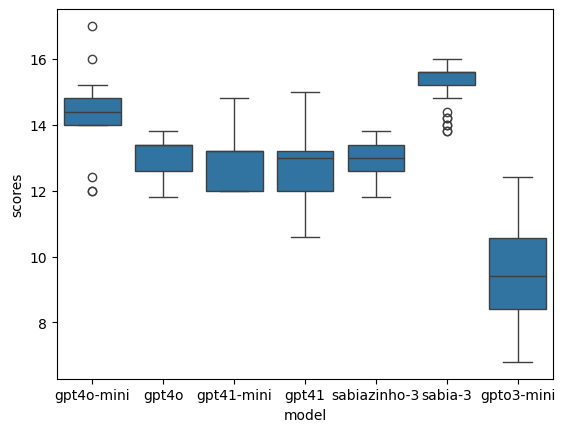

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_model_scores, x='model',y='scores')
plt.show()

Vamos trabalhar com as respostas dadas pelos humanos.

Fizemos anotações com 3 humanos sobre as respostas de um modelo na segunda fase ( questões abertas). Vamos agora desempacotar estas respostas para ver o quanto dá de concordância e divergência e o quanto dá na nota.

In [ ]:

# Caminho da pasta onde estão os arquivos de anotações
folder_path = "./data/"
file1_path = os.path.join(folder_path, "/content/drive/MyDrive/Colab Notebooks/avaliation/humano1_anotacoes_discursivas.json")
file2_path = os.path.join(folder_path, "/content/drive/MyDrive/Colab Notebooks/avaliation/humano2_anotacoes_discursivas.json")
file3_path = os.path.join(folder_path, "/content/drive/MyDrive/Colab Notebooks/avaliation/humano3_anotacoes_discursivas.json")

# Função para carregar as anotações
def load_annotations(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return json.load(file)

# Carregar os arquivos
annotations1 = load_annotations(file1_path)
annotations2 = load_annotations(file2_path)
annotations3 = load_annotations(file3_path)

# Criar um conjunto de todos os critérios avaliados
criteria_set = set()

# Transformar anotações em formato binário corretamente
annotations_bin1 = {}
annotations_bin2 = {}
annotations_bin3 = {}

for question_id, criteria in annotations1.items():
    for criterion, answer in criteria.items():
        criteria_set.add(criterion)
        annotations_bin1[f"{criterion}_1"] = 1 if answer == "Sim" else 0
        annotations_bin1[f"{criterion}_0"] = 1 if answer == "Não" else 0

for question_id, criteria in annotations2.items():
    for criterion, answer in criteria.items():
        criteria_set.add(criterion)
        annotations_bin2[f"{criterion}_1"] = 1 if answer == "Sim" else 0
        annotations_bin2[f"{criterion}_0"] = 1 if answer == "Não" else 0

for question_id, criteria in annotations3.items():
    for criterion, answer in criteria.items():
        criteria_set.add(criterion)
        annotations_bin3[f"{criterion}_1"] = 1 if answer == "Sim" else 0
        annotations_bin3[f"{criterion}_0"] = 1 if answer == "Não" else 0

# Criar conjuntos para o diagrama de Venn
set1 = {k for k, v in annotations_bin1.items() if v == 1}
set2 = {k for k, v in annotations_bin2.items() if v == 1}
set3 = {k for k, v in annotations_bin3.items() if v == 1}
all_possible = {f"{criterion}_1" for criterion in criteria_set} | {f"{criterion}_0" for criterion in criteria_set}

# Itens que não foram respondidos por ninguém
answered = set1 | set2 | set3
non_answered = all_possible - answered

# Contabilizar respostas da interseção (consenso entre avaliadores)
consensus_count = len(set1 & set2 & set3)

In [ ]:
df_human_answers = pd.DataFrame(columns=['humano','exame','area','numero','letra','parte','avaliacao'])

In [ ]:

for ix, specific_set in enumerate([set1,set2,set3]):
    for row in specific_set:
        #print(row)
        r = row.split("_")
        case = {'humano':[ix], 'exame':[r[1]],'area':[r[3]],'numero':[r[6]],'letra':[r[8]],'parte':[r[10]], 'avaliacao':[r[11]] }
        df_human_answers = pd.concat([df_human_answers, pd.DataFrame(case)
                                    ], ignore_index=True)

In [ ]:
df_human_answers_ordered = df_human_answers.sort_values(by=['humano','exame','area','numero','letra','parte'])
df_human_answers_h0 = df_human_answers_ordered.query('humano == 0')
df_human_answers_h1 = df_human_answers_ordered.query('humano == 1')
df_human_answers_h2 = df_human_answers_ordered.query('humano == 2')

In [ ]:
evaluations_h0 = list(df_human_answers_h0['avaliacao'])
evaluations_h1 = list(df_human_answers_h1['avaliacao'])
evaluations_h2 = list(df_human_answers_h2['avaliacao'])


In [ ]:
from statsmodels.stats.inter_rater import fleiss_kappa
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Converte para números inteiros
avaliador1 = list(map(int, evaluations_h0))
avaliador2 = list(map(int, evaluations_h1))
avaliador3 = list(map(int, evaluations_h2))

# Junta as respostas por questão
respostas = list(zip(avaliador1, avaliador2, avaliador3))

# Para cada questão, conta quantos votaram 0 e quantos votaram 1
data = []
for resposta in respostas:
    votos_0 = resposta.count(0)
    votos_1 = resposta.count(1)
    data.append([votos_0, votos_1])

data = np.array(data)

# Calcula o Fleiss' Kappa
kappa = fleiss_kappa(data)

#print("Matriz de votos:")
#print(data)
print(f"Fleiss' Kappa: {round(kappa,3)}")


Fleiss' Kappa: 0.789


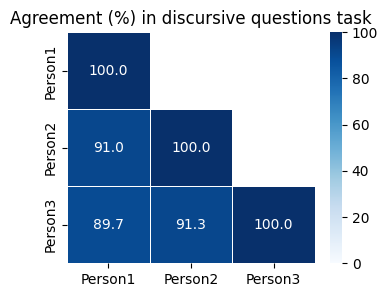

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Converta para np.array para facilitar
avaliadores = [
    np.array(avaliador1, dtype=int),
    np.array(avaliador2, dtype=int),
    np.array(avaliador3, dtype=int)
]

n = len(avaliadores)

# Matriz para guardar a % de concordância
matriz_concordancia = np.zeros((n, n))

# Calcula a % de concordância par a par
for i in range(n):
    for j in range(n):
        iguais = avaliadores[i] == avaliadores[j]
        matriz_concordancia[i, j] = np.mean(iguais) * 100  # porcentagem de acerto

# Converte para DataFrame
df_concordancia = pd.DataFrame(matriz_concordancia,
                               index=[f"Person{i+1}" for i in range(n)],
                               columns=[f"Person{i+1}" for i in range(n)])

# Cria máscara para a parte superior da matriz
mask = np.triu(np.ones_like(df_concordancia, dtype=bool), k=1)

# Plot
plt.figure(figsize=(4, 3))
sns.heatmap(df_concordancia, annot=True, fmt=".1f", cmap="Blues",
            vmin=0, vmax=100, mask=mask, cbar=True, square=False, linewidths=0.5)
plt.title('Agreement (%) in discursive questions task')
plt.show()


golden standard: majority vote

In [ ]:
assert len(avaliador1) == len(avaliador2) == len(avaliador3)

In [ ]:
golden_labels = []
for i in range(len(avaliador1)):
    label = 1 if avaliador1[i]+avaliador2[i]+avaliador3[i] >= 2 else 0
    golden_labels.append(label)

In [ ]:
golden_labels[0:20]

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]

In [ ]:
assert len(golden_labels) == len(avaliador1)

In [ ]:
# Remove o campo 'humano' dos três DataFrames
df_h0 = df_human_answers_h0.drop(columns=['humano']).rename(columns={'avaliacao': 'avaliacao_1'})
df_h1 = df_human_answers_h1.drop(columns=['humano']).rename(columns={'avaliacao': 'avaliacao_2'})
df_h2 = df_human_answers_h2.drop(columns=['humano']).rename(columns={'avaliacao': 'avaliacao_3'})

# Faz o merge
df_human_human_answers2 = df_h0.merge(df_h1, on=['exame', 'area', 'numero', 'letra', 'parte'], how='inner') \
                 .merge(df_h2, on=['exame', 'area', 'numero', 'letra', 'parte'], how='inner')
for ix, row in df_human_human_answers2.iterrows():
    df_human_human_answers2.at[ix, 'golden_label'] = '1' if int(row['avaliacao_1']) + int(row['avaliacao_2']) + int(row['avaliacao_3']) >= 2 else '0'


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(df_human_human_answers2.golden_label, df_human_human_answers2.avaliacao_3))

0.9498680738786279


In [ ]:
assert [str(x) for x in golden_labels] == list(df_human_human_answers2.golden_label)

In [ ]:
# Calcular acurácia individual dos avaliadores
acc1 = accuracy_score(df_human_human_answers2['golden_label'], df_human_human_answers2['avaliacao_1'])
acc2 = accuracy_score(df_human_human_answers2['golden_label'], df_human_human_answers2['avaliacao_2'])
acc3 = accuracy_score(df_human_human_answers2['golden_label'], df_human_human_answers2['avaliacao_3'])

print(f"Accuracy with Golden Label Person1 {round(acc1,3)} Person2 {round(acc2,3)} Person3 {round(acc3,3)} ")

Accuracy with Golden Label Person1 0.947 Person2 0.963 Person3 0.95 


In [ ]:
def corrigir_avaliacao(formated_criteria, evaluation):
    #print('Entrou no corrigir')

    # Remove entradas sem número ou parte
    evaluation = [
        item for item in evaluation
        if item.get('letra') is not None and item.get('parte') is not None
    ]

    # Coleta os pares (numero, parte) que já foram avaliados
    avaliados = {(item['letra'], item['parte']) for item in evaluation}
    #print('Pegou avaliados')

    #faltantes = 0

    for criterio in formated_criteria:
        chave = (criterio['letra'], criterio['parte'])

        if chave not in avaliados:
            novo_item = criterio.copy()
            novo_item['acerto'] = -1
            novo_item['raciocinio'] = 'Critério não avaliado pelo modelo ou falha em representar a estrutura.'
            evaluation.append(novo_item)
            #faltantes += 1
            print(f"[ADICIONADO] Critério {chave} foi incluído com acerto = -1")

    return evaluation

comparacao modelo com humanos

In [ ]:
#mera depuração de erro, ignorar
erros = 0
erros_list = []
for ix, row in df_discursive.query("judge_model == 'sabia-3' ").iterrows():
    #print('ok')
    evaluations1 = row.evaluation
    if 'resultado' in evaluations1:
        evaluations_final = evaluations1['resultado']
    else:
        evaluations_final = row.evaluation

    for evalu in evaluations_final:
        if 'parte' not in evalu:
            erros_list.append(evaluations_final)
            erros = erros + 1
            print('Não encontrou parte...')
            print(f'caso {evalu}')
            print(f'contexto {evaluations_final}')
            print('--------')
print(f'erros {erros}')

Não encontrou parte...
caso {'cache_beaker': 71}
contexto [{'letra': 'A', 'parte': 'I', 'acerto': 1, 'raciocinio': 'O candidato mencionou corretamente a obrigatoriedade da matriz de alocação de riscos em contratos de grande vulto conforme a Lei no 14.133/2021.', 'pontos': 0.55}, {'letra': 'A', 'parte': 'II', 'acerto': 1, 'raciocinio': 'O candidato citou adequadamente o Art. 22, § 3o, da Lei no 14.133/2021, referente à inclusão da matriz de alocação de riscos no edital.', 'pontos': 0.1}, {'letra': 'B', 'parte': 'I', 'acerto': 1, 'raciocinio': 'O candidato afirmou corretamente que é possível exigir a implementação de um programa de integridade em contratos de grande vulto, conforme a Lei no 14.133/2021.', 'pontos': 0.5}, {'letra': 'B', 'parte': 'II', 'acerto': 1, 'raciocinio': 'O candidato mencionou corretamente o Art. 25, § 4o, da Lei no 14.133/2021, que prevê a obrigatoriedade de implementação de programa de integridade.', 'pontos': 0.1}, {'cache_beaker': 71}]
--------
Não encontrou pa

In [ ]:
exams = df_discursive['exam'].unique()
areas = df_discursive['area'].unique()
models = df_discursive['judge_model'].unique()

df_model_scores = pd.DataFrame(columns=['model','scores'])
df_model_answers_discursive = pd.DataFrame(columns=['model','experiment','judge','exam', 'area', 'number', 'letra', 'parte','evaluation', 'score'])

last_case =''
last_context = []
try:
    for model in models:

        print(f'Evaluation {model}')
        for experiment in range(0,10):
             for judge in range(0,5):
                exam_score = 0
                for exam in exams:
                    for area in areas:
                        for number in range(1,5):
                            model_scores  = []
                            for ix, row in df_discursive.query('exam == @exam & area == @area & judge_model == @model & number == @number & judge_number == @judge & experiment == @experiment').iterrows():
                                evaluation = row.evaluation
                                if 'resultado' in evaluation:
                                    evaluation = evaluation['resultado']
                                #print(evaluation)
                                evaluation = corrigir_avaliacao(row.formated_criteria, evaluation)
                                last_context = evaluation
                                # treatment to points
                                if 'pontos' not in evaluation[0]: #so the we need to take the scoring points in reference
                                    for e in evaluation:
                                        last_case = e
                                        if 'parte' not in e or 'acerto' not in e:
                                            print('Sem parte')
                                            #print(z)
                                            continue
                                        e_letra = e['letra']
                                        e_parte = e['parte']
                                        #now we need to find this question in reference
                                        for c in row.formated_criteria:
                                            c_letra = c['letra']
                                            c_parte = c['parte']
                                            if e_letra == c_letra and e_parte == c_parte:
                                                #ok, we found the match, so we need to extract the points
                                                e['pontos'] = c['pontos']
                                for z in evaluation:
                                    #print(z)
                                    if 'parte' not in z or 'acerto' not in z:
                                        print('Sem parte ou acerto')
                                        print(z)
                                        continue

                                    z_letra = z['letra']
                                    z_parte = z['parte']
                                    z_acerto = z['acerto']
                                    z_pontos = z['pontos']
                                    for c in row.formated_criteria:
                                        c_letra = c['letra']
                                        c_parte = c['parte']
                                        if z_letra == c_letra and z_parte == c_parte:
                                            z['pontos'] = c['pontos']


                                    if 'pontos'  in z:
                                        z_pontos = z['pontos']
                                    else:
                                        z_pontos = 0
                                    #print(z_letra, z_parte, z_acerto, z_pontos)
                                    df_model_answers_discursive = pd.concat([df_model_answers_discursive, pd.DataFrame({'model':[model],'experiment':[experiment],'judge':[judge],'exam':[exam],'area':[area],'number':[number],'letra':[z_letra],'parte':[z_parte],'evaluation':[z_acerto],'score':[z_pontos]})], ignore_index=True)

except Exception as e:
    print('ERRO ',e)


Evaluation gpt4o-mini


/tmp/ipython-input-4246962577.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_model_answers_discursive = pd.concat([df_model_answers_discursive, pd.DataFrame({'model':[model],'experiment':[experiment],'judge':[judge],'exam':[exam],'area':[area],'number':[number],'letra':[z_letra],'parte':[z_parte],'evaluation':[z_acerto],'score':[z_pontos]})], ignore_index=True)


Evaluation gpt4o
Evaluation gpt41-mini
Evaluation gpt41
Evaluation sabiazinho-3
[ADICIONADO] Critério ('B', 'III') foi incluído com acerto = -1


/tmp/ipython-input-4246962577.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_model_answers_discursive = pd.concat([df_model_answers_discursive, pd.DataFrame({'model':[model],'experiment':[experiment],'judge':[judge],'exam':[exam],'area':[area],'number':[number],'letra':[z_letra],'parte':[z_parte],'evaluation':[z_acerto],'score':[z_pontos]})], ignore_index=True)


Evaluation sabia-3
Sem parte ou acerto
{'letra': 'A2', 'parte': 'I', 'criterio_extra': 'cache_beaker', 'valor_cache_beaker': 116}
Sem parte ou acerto
{'letra': 'A2', 'parte': 'II', 'criterio_extra': 'cache_beaker', 'valor_cache_beaker': 116}
Sem parte ou acerto
{'letra': 'B', 'parte': 'I', 'criterio_extra': 'cache_beaker', 'valor_cache_beaker': 116}
Sem parte ou acerto
{'letra': 'B', 'parte': 'II', 'criterio_extra': 'cache_beaker', 'valor_cache_beaker': 116}
Evaluation gpto3-mini


In [ ]:
partes_validas = ['I', 'II', 'III', 'IV', 'V', 'VI','VII','VIII','IX','X']
evaluations_validas = [0,1,-1]
df_model_answers2 = df_model_answers_discursive[df_model_answers_discursive['parte'].isin(partes_validas)]
df_model_answers2 = df_model_answers2[df_model_answers2['evaluation'].isin(evaluations_validas)]
df_model_answers2.drop_duplicates(['model','experiment','judge','exam','area','number','letra','parte','evaluation'])
df_model_answers2['model'].value_counts()

,count
model,
sabiazinho-3,18963
gpt4o,18950
gpt4o-mini,18950
gpt41-mini,18950
gpt41,18950
sabia-3,18950
gpto3-mini,18950


In [ ]:
df_model_answers2.to_pickle('respostas_discursivas.pkl')

In [ ]:
df_model_answers2_discursive = pd.read_pickle('respostas_discursivas.pkl')

In [ ]:
def unifica_dfs_discursive(df,df2):
    # Primeiro, renomeie as colunas do df1 para que coincidam com as do df2
    df1_renomeado = df.rename(columns={
        'exam': 'exame',
        'number': 'numero',
        'score': 'potential_score',
        'experiment':'experimento'
    })
    #print('A')
    # Agora faça o merge com base nas colunas relevantes
    df_merged = df2.merge(
        df1_renomeado[['model','experimento','judge','exame', 'area', 'numero', 'parte', 'evaluation','potential_score']],
        on=['exame', 'area', 'numero', 'parte'],
        #how='left'
        how='inner'
    )
    #print('B')

    # Converta explicitamente os tipos das colunas usadas no merge para garantir correspondência
    df['exam'] = df['exam'].astype(str)
    df['area'] = df['area'].astype(str)
    df['number'] = df['number'].astype(str)
    df['parte'] = df['parte'].astype(str)
    df['letra'] = df['letra'].astype(str)
    df['experiment'] = df['experiment'].astype(str)
    df['judge'] = df['judge'].astype(str)

    df2['exame'] = df2['exame'].astype(str)
    df2['area'] = df2['area'].astype(str)
    df2['numero'] = df2['numero'].astype(str)
    df2['parte'] = df2['parte'].astype(str)
    df2['letra'] = df2['letra'].astype(str)

    #print('C')
    # Renomeie para facilitar o merge
    df1_renomeado = df.rename(columns={'exam': 'exame', 'number': 'numero','score': 'potential_score','experiment':'experimento'})

    #print(df1_renomeado.columns)
    # Faça o merge
    df_merged = df2.merge(
        df1_renomeado[['model','experimento','judge','exame', 'area', 'numero','letra', 'parte', 'evaluation','potential_score']],
        on=['exame', 'area', 'numero', 'parte','letra'],
        how='inner'
    )
    #print('D')
    # Renomeie o campo final
    df_merged = df_merged.rename(columns={'evaluation': 'avaliacao_modelo'})
    df_merged['golden_label'] = df_merged['golden_label'].astype(int)
    df_merged['avaliacao_modelo'] = df_merged['avaliacao_modelo'].astype(int)
    df_merged['score_by_golden_label'] =  df_merged['golden_label'] * df_merged['potential_score']
    df_merged['score_by_model'] =  df_merged['avaliacao_modelo'] * df_merged['potential_score']
    return df_merged

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
experiments = list(range(10))
judges = range(5)
exams = range(39,42)

models = list(df_discursive['judge_model'].unique())
#models.remove('sabiazinho-3')
df_all_scores_discursive = pd.DataFrame(columns = ['exame', 'area', 'numero', 'letra', 'parte', 'avaliacao_1',
       'avaliacao_2', 'avaliacao_3', 'golden_label', 'model',
       'avaliacao_modelo', 'potential_score', 'score_by_golden_label','score_by_model'])
areas = list(df_discursive['area'].unique())
df_exp2 = pd.DataFrame(columns = ['model','exam','experiment','judge','cohen_kappa','accuracy','score_spearman_corr','score_spearman_p','score_pearson_corr','score_pearson_p','score_mae'])
df_exp3 = pd.DataFrame(columns = ['model','exam','experiment','judge','area','cohen_kappa','accuracy'])
for model in models:
    print(model)
    for exam in exams:
        for experiment in experiments:
            for judge in judges:
                #print(model, exam, experiment, judge)
                df = df_model_answers2_discursive.query('model == @model and judge == @judge and exam == @exam and experiment == @experiment')
                exam_s = str(exam)
                df2 = df_human_human_answers2.query('exame == @exam_s ')
                #df_ordered = df.sort_values(by=['exam','area','number','letra','parte'])
                #df2_ordered = df2.sort_values(by=['exame','area','numero','letra','parte'])
                #df_ordered['evaluation'] = df_ordered['evaluation'].astype(str)
                df_merged = unifica_dfs_discursive(df,df2)
                df_all_scores_discursive = pd.concat([df_all_scores_discursive, df_merged],ignore_index=True)
                accuracy= accuracy_score(df_merged.golden_label, df_merged.avaliacao_modelo)
                cohen_kappa = cohen_kappa_score(df_merged.golden_label, df_merged.avaliacao_modelo)
                pearson_corr, pearson_p = pearsonr(df_merged['score_by_golden_label'], df_merged['score_by_model'])
                spearman_corr, spearman_p = spearmanr(df_merged['score_by_golden_label'], df_merged['score_by_model'])
                score_mae = mean_absolute_error(df_merged['score_by_golden_label'], df_merged['score_by_model'])
                df_exp2 = pd.concat([df_exp2,pd.DataFrame({'model':[model], 'exam': [exam], 'experiment': [experiment], 'judge':[judge], 'cohen_kappa':[cohen_kappa],'accuracy':[accuracy],
                'score_spearman_corr': [spearman_corr],'score_spearman_p': [spearman_p],
                'score_pearson_corr': [pearson_corr], 'score_pearson_p': [pearson_p],
                'score_mae': [score_mae]}) ],ignore_index=True)
                #agora coloca area por area
                for area in areas:
                    df_discursive_area = df_merged.query("area == @area")
                    accuracy_area= accuracy_score(df_discursive_area.golden_label, df_discursive_area.avaliacao_modelo)
                    cohen_kappa_area = cohen_kappa_score( df_discursive_area.golden_label,  df_discursive_area.avaliacao_modelo)
                    pearson_corr, pearson_p = pearsonr(df_discursive_area['score_by_golden_label'], df_discursive_area['score_by_model'])
                    spearman_corr, spearman_p = spearmanr(df_discursive_area['score_by_golden_label'], df_discursive_area['score_by_model'])
                    score_mae = mean_absolute_error(df_discursive_area['score_by_golden_label'], df_discursive_area['score_by_model'])
                    df_exp3 = pd.concat([df_exp3,pd.DataFrame({'model':[model], 'exam': [exam], 'experiment': [experiment], 'judge':[judge],'area':[area], 'cohen_kappa':[cohen_kappa_area],'accuracy':[accuracy_area],
                    'score_spearman_corr': [spearman_corr],'score_spearman_p': [spearman_p],
                    'score_pearson_corr': [pearson_corr], 'score_pearson_p': [pearson_p],
                    'score_mae': [score_mae]}) ],ignore_index=True)



gpt4o-mini
gpt4o
gpt41-mini
gpt41
sabiazinho-3
sabia-3
gpto3-mini


In [ ]:
df_discursive_scores = pd.DataFrame(columns=['model','exame','area','experimento','judge','score_by_golden_label', 'score_by_model','normalized_score_by_golden_label','normalized_score_by_model'])
all = df_all_scores_discursive.groupby(['model','exame','area','experimento','judge'])[['score_by_golden_label', 'score_by_model']].sum()
for index, row in all.iterrows():
    model, exame, area, experimento, judge = index  # descompacta os índices do grupo
    score_golden = row['score_by_golden_label']
    score_model = row['score_by_model']
    normalized_score_golden = score_golden *20
    normalized_score_model = score_golden *20
    df_discursive_scores = pd.concat([df_discursive_scores, pd.DataFrame([{
    'model': model,
    'exame': exame,
    'area': area,
    'experimento': experimento,
    'judge': judge,
    'score_by_golden_label': score_golden,
    'score_by_model': score_model,
    'normalized_score_by_golden_label': score_golden *20,
    'normalized_score_by_model': score_model *20
}])], ignore_index=True)


In [ ]:
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import pandas as pd

# DataFrame de saída
df_metricas = pd.DataFrame(columns=[
    'model', 'area', 'experimento',
    'mae_normalized',
    'pearson_corr', 'pearson_pvalue',
    'spearman_corr', 'spearman_pvalue'
])

# Agrupamento por model, area, experimento
agrupado = df_discursive_scores.groupby(['model', 'area', 'experimento'])

for (model, area, experimento), grupo in agrupado:
    # Extrai os vetores normalizados
    golden_scores = grupo['normalized_score_by_golden_label'].astype(float)
    model_scores = grupo['normalized_score_by_model'].astype(float)

    # Calcula as métricas
    mae = mean_absolute_error(golden_scores, model_scores)
    pearson_corr, pearson_p = pearsonr(golden_scores, model_scores)
    spearman_corr, spearman_p = spearmanr(golden_scores, model_scores)

    # Adiciona à tabela de resultados
    df_metricas = pd.concat([df_metricas, pd.DataFrame([{
        'model': model,
        'area': area,
        'experimento': experimento,
        'mae_normalized': mae,
        'pearson_corr': pearson_corr,
        'pearson_pvalue': pearson_p,
        'spearman_corr': spearman_corr,
        'spearman_pvalue': spearman_p
    }])], ignore_index=True)

In [ ]:
df_discursive_scores

,model,exame,area,experimento,judge,score_by_golden_label,score_by_model,normalized_score_by_golden_label,normalized_score_by_model
0,gpt41,39,administrativo,0,0,3.5,3.50,70.0,70.0
1,gpt41,39,administrativo,0,1,3.5,4.00,70.0,80.0
2,gpt41,39,administrativo,0,2,3.5,4.00,70.0,80.0
3,gpt41,39,administrativo,0,3,3.5,4.00,70.0,80.0
4,gpt41,39,administrativo,0,4,3.5,4.00,70.0,80.0
...,...,...,...,...,...,...,...,...,...
7345,sabiazinho-3,41,tributário,9,0,2.7,1.15,54.0,23.0
7346,sabiazinho-3,41,tributário,9,1,2.7,1.15,54.0,23.0
7347,sabiazinho-3,41,tributário,9,2,2.7,1.05,54.0,21.0
7348,sabiazinho-3,41,tributário,9,3,2.7,1.05,54.0,21.0


In [ ]:
df_metricas

,model,area,experimento,mae_normalized,pearson_corr,pearson_pvalue,spearman_corr,spearman_pvalue
0,gpt41,administrativo,0,4.066667,0.977616,3.505061e-10,0.882523,0.000013
1,gpt41,administrativo,1,3.666667,0.936173,2.876891e-07,0.870877,0.000024
2,gpt41,administrativo,2,6.933333,0.932721,4.017540e-07,0.552006,0.032882
3,gpt41,administrativo,3,5.466667,0.979091,2.257939e-10,0.773389,0.000719
4,gpt41,administrativo,4,6.066667,0.955464,2.906759e-08,0.675454,0.005718
...,...,...,...,...,...,...,...,...
485,sabiazinho-3,tributário,5,15.533333,-0.908584,2.776978e-06,-0.844350,0.000075
486,sabiazinho-3,tributário,6,15.800000,-0.915049,1.751712e-06,-0.840366,0.000088
487,sabiazinho-3,tributário,7,13.733333,-0.888304,9.712100e-06,-0.840366,0.000088
488,sabiazinho-3,tributário,8,15.666667,-0.919274,1.270560e-06,-0.845154,0.000073


agora vamos pegar as respostas da primeira fase

In [ ]:
df_objective = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/avaliation/respostas_objetivas_com_area.pkl')

In [ ]:
df_objective['area'].unique()

array(['ética', 'filosofia', 'constitucional', 'direitos humanos',
       'eleitoral', 'internacional', 'financeiro', 'tributario',
       'administrativo', 'ambiental', 'civil', 'ECA', 'consumidor',
       'empresarial', 'processo civil', 'penal', 'processo penal',
       'previdenciario', 'trabalho', 'processo do trabalho'], dtype=object)

In [ ]:
dict_areas =  {'civil': ['civil','processo sivil'],
               'penal': ['penal','processo penal'],
               'trabalhista' : ['trabalho','processo do trabalho'],
               'tributário': ['tributario'],
               'administrativo': ['administrativo'],
               'constitucional': ['constitucional'],
               'empresarial': ['empresarial']
               }

In [ ]:
def first_phase_score_area(df,area,model, exam):
    areas = dict_areas[area]

    df_area = df.query("area in @areas and model == @model and exam == @exam  ")
    qtd = len(df_area)
    acertos = len(df_area.query("model_answer == answer"))
    score = acertos/qtd *100
    return round(score,2)


In [ ]:
def target_score_area(df,area, model, exam):
    exam= str(exam)
    df_area = df.query("area == @area  and model == @model and exame == @exam ")
    score = df_area['normalized_score_by_golden_label'].mean()
    return round(score,2)

In [ ]:
def second_phase_score_area(df,area, model, exam):

    exam= str(exam)
    df_area = df.query("area == @area and model == @model and  exame == @exam ")
    score = df_area['normalized_score_by_model'].mean()
    return round(score,2)

In [ ]:
dict_models = {'gpt4o':'gpt_4o', 'gpt4o-mini':  'gpt_4o_mini', 'gpto3-mini':'gpt_o3_mini',  'sabiazinho-3' :'sabiazinho3','sabia-3' : 'sabia3', 'gpt41': 'gpt_41', 'gpt41-mini':   'gpt_41_mini'    }

In [ ]:
df_proxy_experiment_discursive = pd.DataFrame(columns=['model','exam','area','first_phase','discursive','target'])
exames = [e for e in  list(df_objective['exam'].unique()) if e in list(df_discursive['exam'].unique())]
print(exames)
for area in list(df_discursive['area'].unique()):
    for model in list(df_discursive['judge_model'].unique()):
        for exame in exames:
            #print(model, area)
            first_phase = first_phase_score_area(df_objective,area,dict_models[model], exame)
            second_phase = second_phase_score_area(df_discursive_scores ,area,model, exame)
            target = target_score_area(df_discursive_scores ,area,model, exame)
            df_proxy_experiment_discursive = pd.concat([df_proxy_experiment_discursive, pd.DataFrame({'model': [model],'exam': [exame],'area':[area], 'first_phase': [first_phase], 'discursive': [second_phase], 'target': [target]})],ignore_index=True)
df_proxy_experiment_discursive.sample(3)

[41, 40]


,model,exam,area,first_phase,discursive,target
17,gpt4o,40,civil,66.67,65.32,67.0
43,gpt4o-mini,40,empresarial,75.00,50.00,31.0
19,gpt41-mini,40,civil,83.33,64.50,67.0


In [ ]:

# DataFrame final com area incluída
df_proxy_experiment_discursive_scores = pd.DataFrame(columns=[
    'model', 'area',
    'mean_first_phase', 'mean_discursive', 'mean_target',
    'mae_first_phase', 'mae_discursive',
    'rmse_first_phase', 'rmse_discursive',

])


# Iteração por modelo e área
for (model, area), group in df_proxy_experiment_discursive.groupby(['model', 'area']):
    x1 = group['first_phase'].values.reshape(-1, 1)
    x2 = group['discursive'].values.reshape(-1, 1)
    y = group['target'].values


    df_proxy_experiment_discursive_scores = pd.concat([df_proxy_experiment_discursive_scores, pd.DataFrame({
        'model': [model],
        'area': [area],
        'mean_first_phase': [round(np.mean(group['first_phase']),2)],
        'mean_discursive': [round(np.mean(group['discursive']),2)],
        'mean_target': [round(np.mean(group['target']),2)],
        'mae_first_phase': [round(mean_absolute_error(y, group['first_phase']),2)],
        'mae_discursive': [round(mean_absolute_error(y, group['discursive']),2)],
        'rmse_first_phase': [round(np.sqrt(mean_squared_error(y, group['first_phase'])),2)],
        'rmse_discursive': [round(np.sqrt(mean_squared_error(y, group['discursive'])),2)],
    })], ignore_index=True)
    #print(round(np.sqrt(mean_squared_error(y, group['first_phase'])),2))


In [ ]:
df_proxy_experiment_discursive_scores.groupby(['model'])[['mean_first_phase','mean_discursive','mean_target','mae_first_phase','mae_discursive','rmse_first_phase','rmse_discursive']].mean()

,mean_first_phase,mean_discursive,mean_target,mae_first_phase,mae_discursive,rmse_first_phase,rmse_discursive
model,,,,,,,
gpt41,70.715714,47.317143,44.571429,27.904286,7.237143,31.424286,7.734286
gpt41-mini,79.761429,47.391429,44.571429,35.190000,7.340000,36.664286,7.805714
gpt4o,85.475714,43.681429,44.571429,40.951429,5.335714,42.455714,6.088571
gpt4o-mini,64.642857,57.350000,44.571429,21.500000,13.512857,23.002857,13.948571
gpto3-mini,66.072857,31.631429,44.571429,22.975714,12.940000,24.798571,14.881429
sabia-3,76.428571,58.172857,44.571429,31.857143,13.907143,32.948571,15.520000
sabiazinho-3,69.287143,44.355714,44.581429,26.134286,11.082857,28.540000,12.468571


In [ ]:
df_proxy_experiment_discursive_scores.query('model == "gpt4o"')

,model,area,mean_first_phase,mean_discursive,mean_target,mae_first_phase,mae_discursive,rmse_first_phase,rmse_discursive
14,gpt4o,administrativo,90.00,40.92,42.0,48.00,1.08,48.84,1.53
15,gpt4o,civil,75.00,54.18,57.5,17.83,3.32,24.98,3.70
16,gpt4o,constitucional,75.00,41.25,45.5,29.50,4.25,29.52,5.05
17,gpt4o,empresarial,100.00,47.54,45.5,54.50,8.60,56.40,8.84
18,gpt4o,penal,83.33,40.38,36.0,47.33,5.38,47.59,6.94
19,gpt4o,trabalhista,85.00,43.32,42.5,42.50,9.18,42.85,9.22
20,gpt4o,tributário,90.00,38.18,43.0,47.00,5.54,47.01,7.34


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut

# DataFrame de saída para armazenar os resultados da validação cruzada
df_proxy_experiment_discursive_scores_cv_regression = pd.DataFrame(columns=[
    'model',
    'r2_first_phase', 'r2_discursive', # Renomeado, pois não é mais uma média
    'coef_first_phase_mean', 'coef_discursive_mean',
    'mae_first_phase_mean', 'mae_discursive_mean',
    'rmse_first_phase_mean', 'rmse_discursive_mean',
    'coef_first_phase_std', 'coef_discursive_std'
])

# Itera por modelo
for model, group in df_proxy_experiment_discursive_scores.groupby('model'):
    if len(group) < 2: continue

    x1 = group['mean_first_phase'].values.reshape(-1, 1)
    x2 = group['mean_discursive'].values.reshape(-1, 1)
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # --- Processamento para a primeira fase (x1) ---
    y_true_all_1, y_pred_all_1 = [], []
    scores1_mae, scores1_rmse, coefs1 = [], [], [] # Lista para R2 removida

    for train_index, test_index in loo.split(x1):
        x1_train, x1_test = x1[train_index], x1[test_index]
        y_train, y_test = y[train_index], y[test_index]

        reg1 = LinearRegression().fit(x1_train, y_train)
        y_pred1 = reg1.predict(x1_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all_1.extend(y_test)
        y_pred_all_1.extend(y_pred1)
        coefs1.append(reg1.coef_[0])
        scores1_mae.append(mean_absolute_error(y_test, y_pred1))
        scores1_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred1)))

    # >>> CÁLCULO FEITO UMA ÚNICA VEZ, DEPOIS DO LOOP <<<
    r2_overall_1 = r2_score(y_true_all_1, y_pred_all_1)


    # --- Processamento para a segunda fase (x2) ---
    y_true_all_2, y_pred_all_2 = [], [] # Variáveis corrigidas para a fase 2
    scores2_mae, scores2_rmse, coefs2 = [], [], []

    for train_index, test_index in loo.split(x2):
        x2_train, x2_test = x2[train_index], x2[test_index]
        y_train, y_test = y[train_index], y[test_index]

        reg2 = LinearRegression().fit(x2_train, y_train)
        y_pred2 = reg2.predict(x2_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all_2.extend(y_test)
        y_pred_all_2.extend(y_pred2)
        coefs2.append(reg2.coef_[0])
        scores2_mae.append(mean_absolute_error(y_test, y_pred2))
        scores2_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred2)))

    # >>> CÁLCULO FEITO UMA ÚNICA VEZ, DEPOIS DO LOOP <<<
    r2_overall_2 = r2_score(y_true_all_2, y_pred_all_2)


    # Adiciona os resultados ao DataFrame
    df_proxy_experiment_discursive_scores_cv_regression = pd.concat([df_proxy_experiment_discursive_scores_cv_regression, pd.DataFrame({
        'model': [model],
        'r2_first_phase': [r2_overall_1], # Usa o valor geral calculado
        'r2_discursive': [r2_overall_2],  # Usa o valor geral calculado
        'coef_first_phase_mean': [np.mean(coefs1)],
        'coef_discursive_mean': [np.mean(coefs2)],
        'mae_first_phase_mean': [np.mean(scores1_mae)],
        'mae_discursive_mean': [np.mean(scores2_mae)],
        'rmse_first_phase_mean': [np.mean(scores1_rmse)],
        'rmse_discursive_mean': [np.mean(scores2_rmse)],
        'coef_first_phase_std': [np.std(coefs1)],
        'coef_discursive_std': [np.std(coefs2)],
    })], ignore_index=True)

In [ ]:
df_proxy_experiment_discursive_scores_cv_regression

,model,r2_first_phase,r2_discursive,coef_first_phase_mean,coef_discursive_mean,mae_first_phase_mean,mae_discursive_mean,rmse_first_phase_mean,rmse_discursive_mean,coef_first_phase_std,coef_discursive_std
0,gpt41,-5.177118,-0.494059,0.279912,0.642572,9.751030,6.478934,9.751030,6.478934,0.312436,0.231226
1,gpt41-mini,-0.794062,-0.471320,0.333975,0.700498,6.314376,6.416747,6.314376,6.416747,0.143451,0.248001
2,gpt4o,-1.089894,0.209321,-0.290994,0.959352,6.636085,4.577904,6.636085,4.577904,0.193284,0.221433
3,gpt4o-mini,-1.051007,-0.798240,0.309829,0.443978,6.542177,5.994872,6.542177,5.994872,0.170043,0.227099
4,gpto3-mini,-0.727887,-0.356228,-0.053640,0.884086,5.919777,5.060808,5.919777,5.060808,0.096147,0.314984
5,sabia-3,-1.907108,-0.569673,0.188032,0.302915,7.287522,6.010087,7.287522,6.010087,0.190662,0.123323
6,sabiazinho-3,-0.811624,-0.593708,0.132192,0.295362,5.984998,6.228820,5.984998,6.228820,0.169688,0.120668


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut

# DataFrame de saída para os resultados da validação cruzada
df_proxy_experiment_discursive_scores_cv_random_regression = pd.DataFrame(columns=[
    'model',
    'r2_first_phase', 'r2_discursive',
    'mae_first_phase_mean', 'mae_discursive_mean',
    'rmse_first_phase_mean', 'rmse_discursive_mean'
])

# Itera por modelo
for model, group in df_proxy_experiment_discursive_scores.groupby('model'):
    if len(group) < 2: continue # Pula se não for possível fazer a validação

    x1 = group['mean_first_phase'].values.reshape(-1, 1)
    x2 = group['mean_discursive'].values.reshape(-1, 1)
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # --- Processamento para a primeira fase (x1) ---
    y_true_all_1, y_pred_all_1 = [], []
    scores1_mae, scores1_rmse = [], []

    for train_index, test_index in loo.split(x1):
        x1_train, x1_test = x1[train_index], x1[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Instancia e treina o modelo RandomForest
        reg1 = RandomForestRegressor(random_state=42).fit(x1_train, y_train)
        y_pred1 = reg1.predict(x1_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all_1.extend(y_test)
        y_pred_all_1.extend(y_pred1)
        scores1_mae.append(mean_absolute_error(y_test, y_pred1))
        scores1_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred1)))

    # Calcula o R² geral e a média dos erros DEPOIS que o loop terminar
    r2_overall_1 = r2_score(y_true_all_1, y_pred_all_1)


    # --- Processamento para a segunda fase (x2) ---
    y_true_all_2, y_pred_all_2 = [], []
    scores2_mae, scores2_rmse = [], []

    for train_index, test_index in loo.split(x2):
        x2_train, x2_test = x2[train_index], x2[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Instancia e treina o modelo RandomForest
        reg2 = RandomForestRegressor(random_state=42).fit(x2_train, y_train)
        y_pred2 = reg2.predict(x2_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all_2.extend(y_test)
        y_pred_all_2.extend(y_pred2)
        scores2_mae.append(mean_absolute_error(y_test, y_pred2))
        scores2_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred2)))

    # Calcula o R² geral e a média dos erros DEPOIS que o loop terminar
    r2_overall_2 = r2_score(y_true_all_2, y_pred_all_2)


    # Adiciona os resultados robustos ao DataFrame
    df_proxy_experiment_discursive_scores_cv_random_regression = pd.concat([df_proxy_experiment_discursive_scores_cv_random_regression, pd.DataFrame({
        'model': [model],
        'r2_first_phase': [r2_overall_1],
        'r2_discursive': [r2_overall_2],
        'mae_first_phase_mean': [np.mean(scores1_mae)],
        'mae_discursive_mean': [np.mean(scores2_mae)],
        'rmse_first_phase_mean': [np.mean(scores1_rmse)],
        'rmse_discursive_mean': [np.mean(scores2_rmse)],
    })], ignore_index=True)


In [ ]:
df_proxy_experiment_discursive_scores_cv_random_regression

,model,r2_first_phase,r2_discursive,mae_first_phase_mean,mae_discursive_mean,rmse_first_phase_mean,rmse_discursive_mean
0,gpt41,-0.765449,-0.103139,6.435000,4.812143,6.435000,4.812143
1,gpt41-mini,-0.687257,-0.303225,6.139286,5.776429,6.139286,5.776429
2,gpt4o,-0.233406,-0.044677,5.171310,4.879286,5.171310,4.879286
3,gpt4o-mini,-0.774698,-0.472566,6.636429,5.485714,6.636429,5.485714
4,gpto3-mini,-1.586766,0.163762,6.576929,4.050000,6.576929,4.050000
5,sabia-3,-0.518356,-0.622097,6.014571,5.652143,6.014571,5.652143
6,sabiazinho-3,-1.245278,-0.149298,6.720614,5.105971,6.720614,5.105971


In [ ]:
# --- SEU CÓDIGO ATÉ A COMBINAÇÃO (ESTÁ CORRETO) ---
df_rf_uni = df_proxy_experiment_discursive_scores_cv_random_regression.copy()
df_rf_uni['algorithm'] = 'Random Forest'

df_lr_uni = df_proxy_experiment_discursive_scores_cv_regression.copy()
df_lr_uni['algorithm'] = 'Regressão Linear'

df_combined_uni = pd.concat([df_rf_uni, df_lr_uni], ignore_index=True)


# --- PASSO DE CORREÇÃO: PADRONIZAR OS NOMES DAS COLUNAS ---
df_combined_uni.rename(columns={
    'mae_first_phase_mean': 'mae_first_phase',
    'rmse_first_phase_mean': 'rmse_first_phase',
    'mae_discursive_mean': 'mae_discursive',
    'rmse_discursive_mean': 'rmse_discursive'
}, inplace=True)

# -------------------------------------------------------------

# 3. Reestruturar o DataFrame para o formato "longo" (AGORA VAI FUNCIONAR)
df_long = pd.wide_to_long(
    df_combined_uni,
    stubnames=['r2', 'mae', 'rmse'],
    i=['model', 'algorithm'],
    j='feature',
    sep='_',
    suffix='\\w+'
).reset_index()

# 4. Renomear os valores da coluna 'feature' para maior clareza
df_long['feature'] = df_long['feature'].replace({
    'first_phase': 'Apenas 1ª Fase',
    'discursive': 'Apenas Discursiva'
})

# 5. Criar a tabela com os eixos INTERCALADOS
interleaved_table = df_long.pivot_table(
    index=['feature', 'algorithm'],
    columns='model',
    values=['r2', 'mae', 'rmse']
)

# 6. Reordenar as colunas para agrupar por métrica
interleaved_table = interleaved_table.swaplevel(0, 1, axis=1).sort_index(axis=1)

# 7. Exibir a tabela final com estilização
print("--- Tabela Comparativa Intercalada (Fase > Algoritmo ML) ---")

mae_rmse_cols = [col for col in interleaved_table.columns if col[0] in ['mae', 'rmse']]
r2_cols = [col for col in interleaved_table.columns if col[0] == 'r2']

styled_interleaved_table = interleaved_table.style.format("{:.3f}").background_gradient(
    cmap='viridis_r', subset=mae_rmse_cols
).background_gradient(
    cmap='viridis', subset=r2_cols
)

styled_interleaved_table

--- Tabela Comparativa Intercalada (Fase > Algoritmo ML) ---


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut

# DataFrame de saída para os resultados da validação cruzada
df_proxy_experiment_discursive_scores_cv_bivariate_regression = pd.DataFrame(columns=[
    'model',
    'r2_combined',
    'mae_combined_mean', 'rmse_combined_mean',
    'coef_first_phase_mean', 'coef_discursive_mean',
    'coef_first_phase_std', 'coef_discursive_std'
])

# Itera por modelo
for model, group in df_proxy_experiment_discursive_scores.groupby('model'):
    if len(group) < 2: continue # Pula se não for possível fazer a validação

    # Features combinadas: primeira e segunda fase
    X = group[['mean_first_phase', 'mean_discursive']].values
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # Listas para armazenar os resultados de cada iteração (fold)
    y_true_all, y_pred_all = [], []
    scores_mae, scores_rmse = [], []
    coefs_first_phase, coefs_discursive = [], [] # Listas separadas para cada coeficiente

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Instancia e treina o modelo de regressão múltipla
        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        scores_mae.append(mean_absolute_error(y_test, y_pred))
        scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

        # Armazena os dois coeficientes separadamente
        coefs_first_phase.append(reg.coef_[0])
        coefs_discursive.append(reg.coef_[1])

    # Calcula as métricas agregadas DEPOIS que o loop terminar
    r2_overall = r2_score(y_true_all, y_pred_all)


    # Adiciona os resultados robustos ao DataFrame
    df_proxy_experiment_discursive_scores_cv_bivariate_regression = pd.concat([df_proxy_experiment_discursive_scores_cv_bivariate_regression, pd.DataFrame({
        'model': [model],
        'r2_combined': [r2_overall],
        'mae_combined_mean': [np.mean(scores_mae)],
        'rmse_combined_mean': [np.mean(scores_rmse)],
        'coef_first_phase_mean': [np.mean(coefs_first_phase)],
        'coef_discursive_mean': [np.mean(coefs_discursive)],
        'coef_first_phase_std': [np.std(coefs_first_phase)],
        'coef_discursive_std': [np.std(coefs_discursive)],
    })], ignore_index=True)

In [ ]:
df_proxy_experiment_discursive_scores_cv_bivariate_regression

,model,r2_combined,mae_combined_mean,rmse_combined_mean,coef_first_phase_mean,coef_discursive_mean,coef_first_phase_std,coef_discursive_std
0,gpt41,-4.514332,10.943041,10.943041,0.101907,0.623076,0.310890,0.331596
1,gpt41-mini,-1.068404,7.989911,7.989911,0.184927,0.505603,0.143582,0.259912
2,gpt4o,0.231782,4.443720,4.443720,-0.131108,0.916679,0.064720,0.200432
3,gpt4o-mini,-4.892299,11.227607,11.227607,0.354533,0.308427,0.317043,0.473187
4,gpto3-mini,-0.944031,6.074997,6.074997,0.025978,0.882231,0.083459,0.383775
5,sabia-3,-3.378021,10.430351,10.430351,0.240293,0.266612,0.226867,0.215097
6,sabiazinho-3,-1.054872,7.534092,7.534092,0.048534,0.295522,0.147407,0.132987


o mae será calculado por área, modelo e experimento. assim, juízes e exames  formam os 15 valores que comporão 1 MAE; teremos 10 MAES para ser possível fazer o boxplot

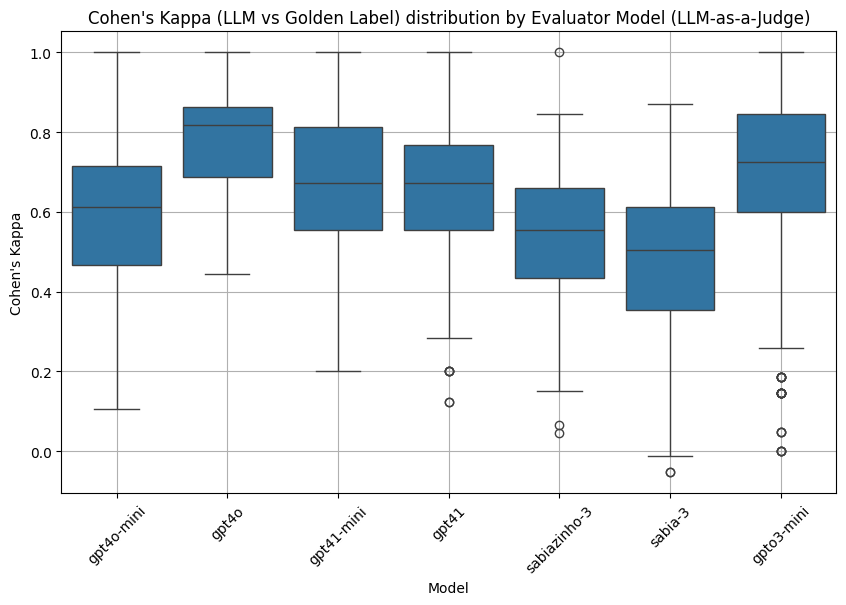

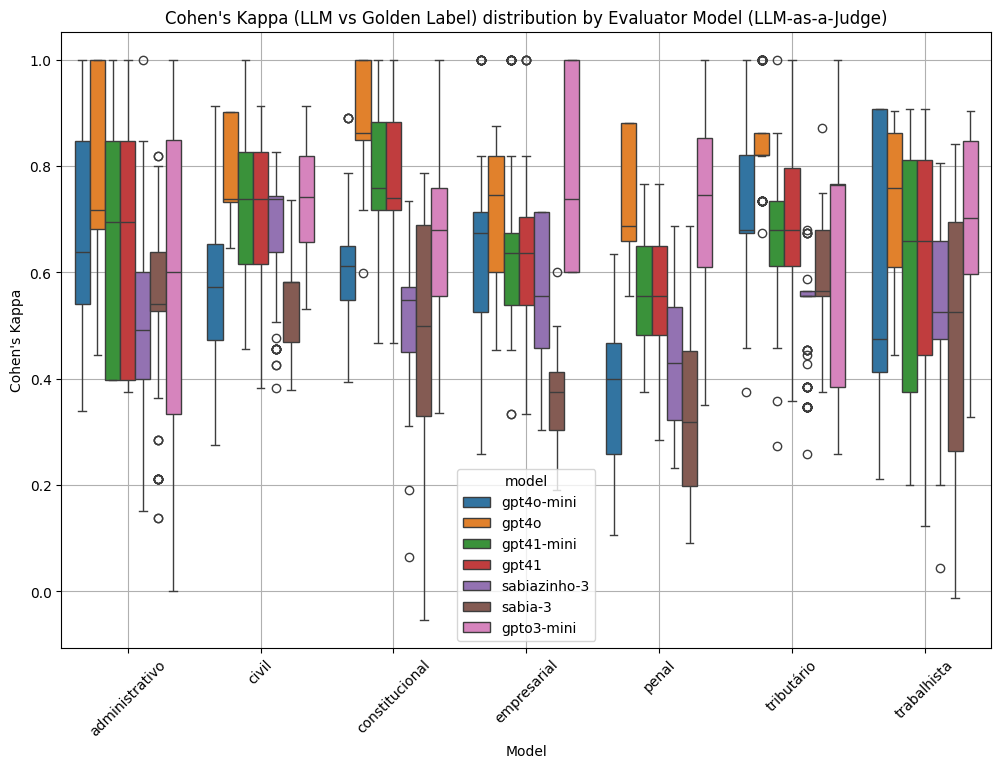

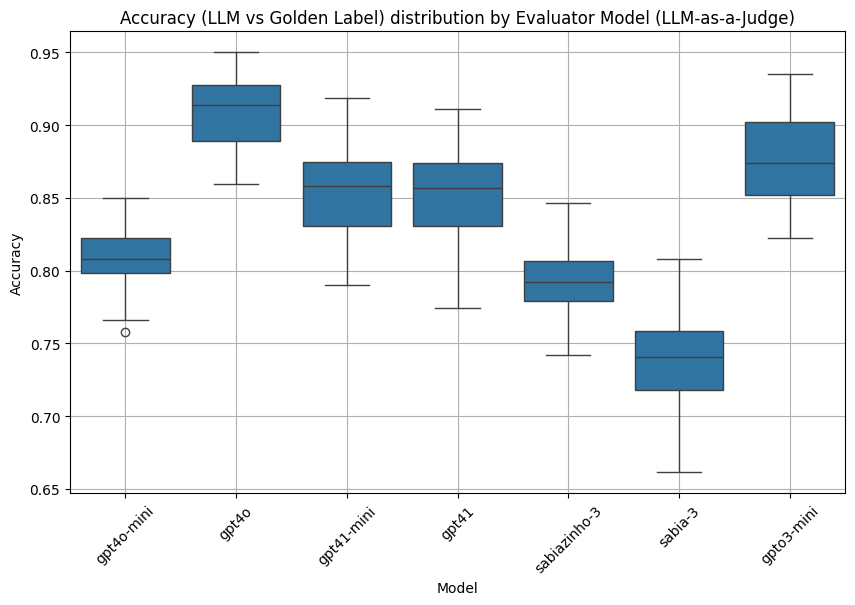

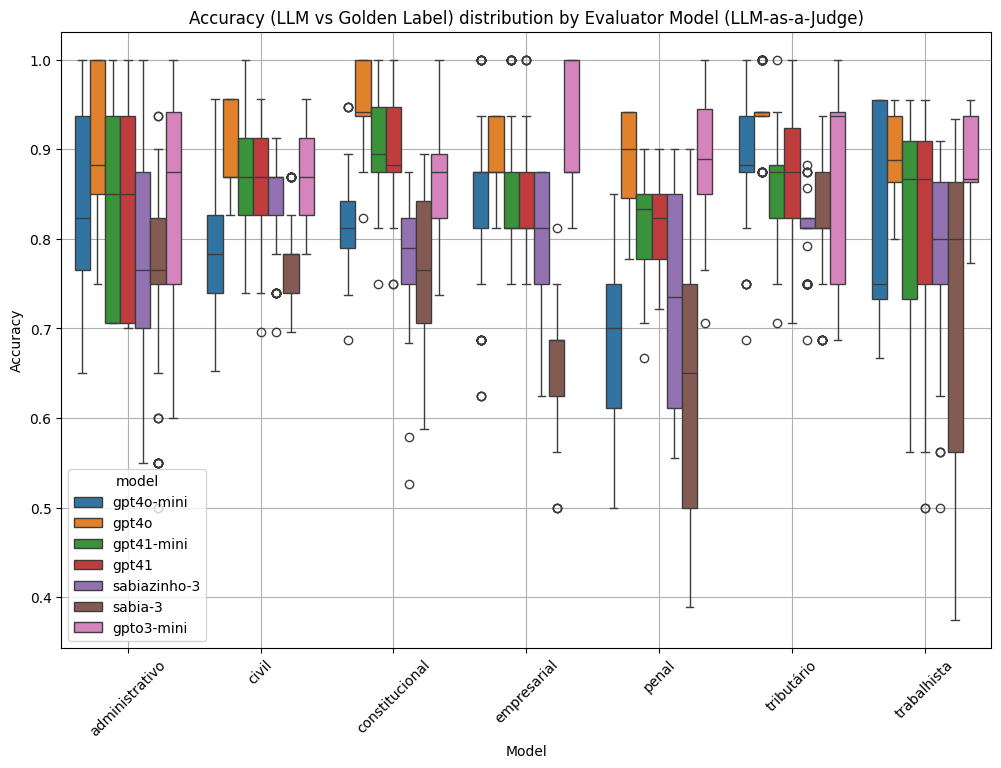

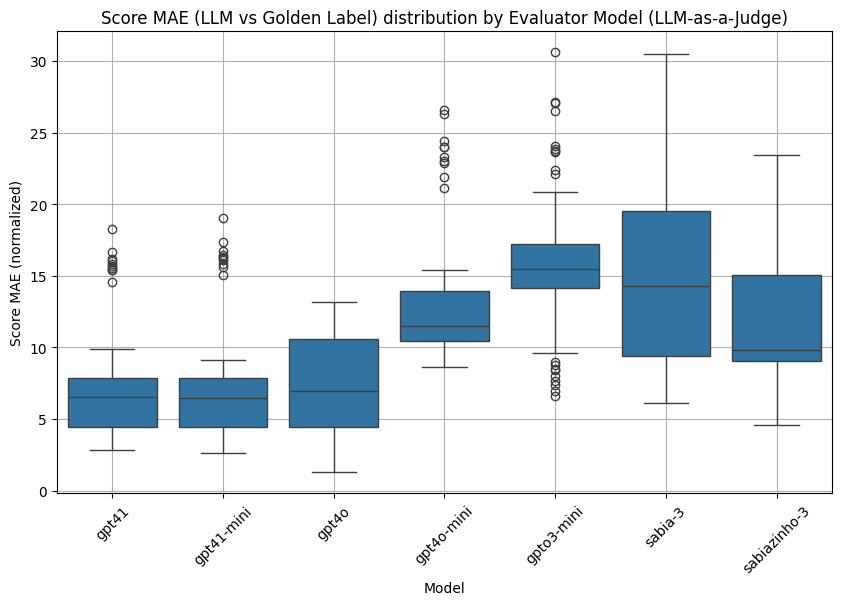

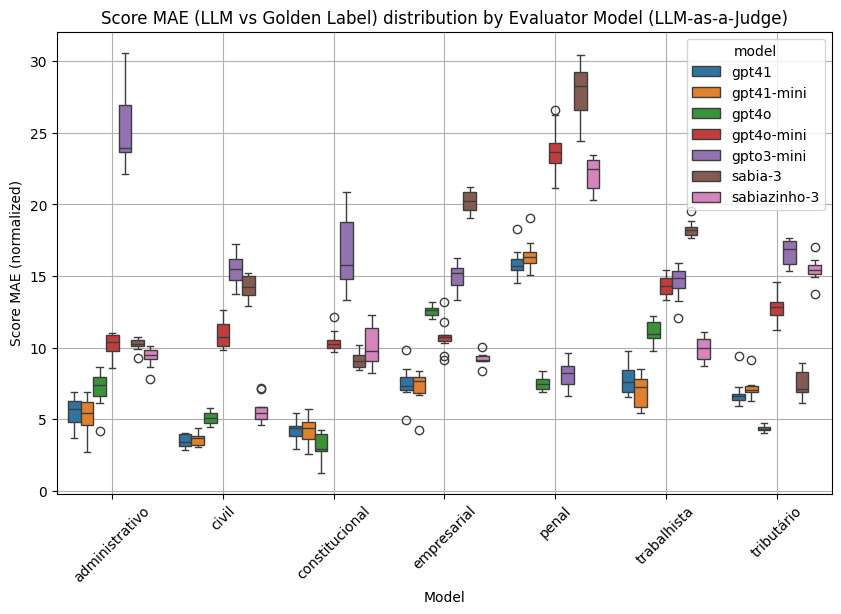

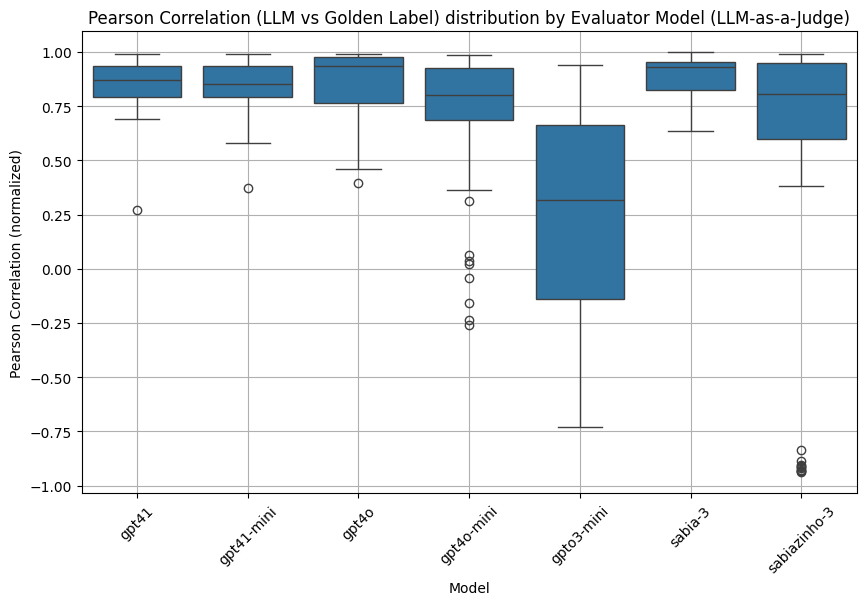

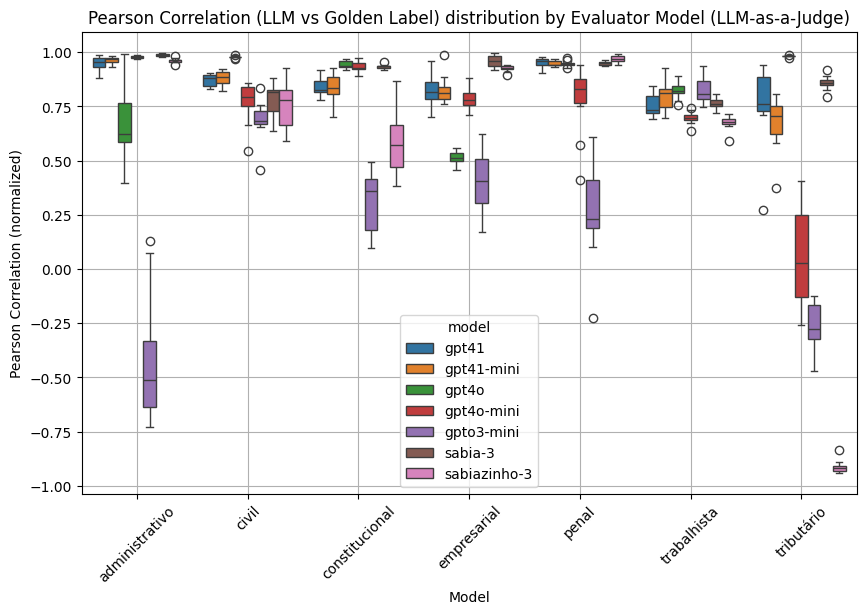

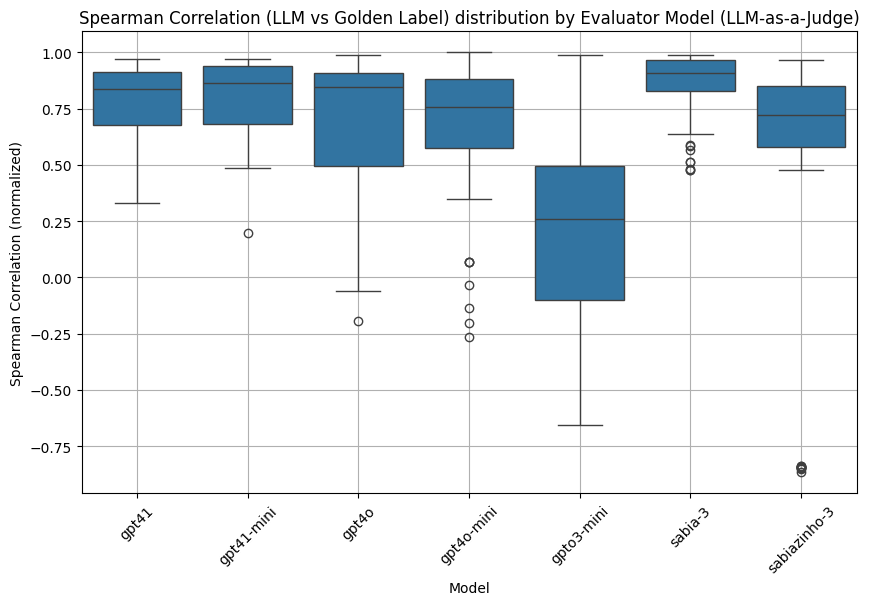

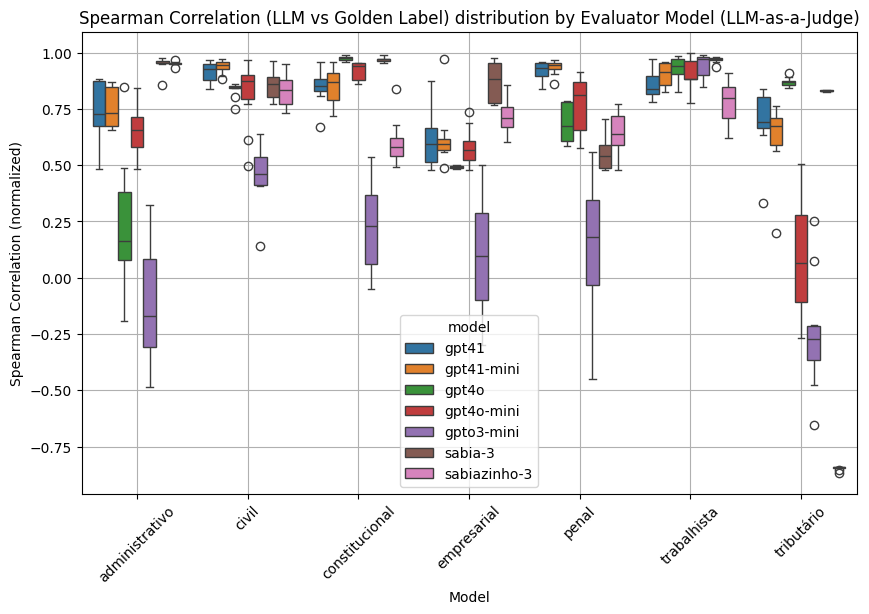

Summary of Cohen's Kappa:


,Mean,Median,Standard Deviation,95% CI Lower,95% CI Upper
model,,,,,
gpt41,0.676,0.689,0.066,0.666,0.687
gpt41-mini,0.683,0.694,0.067,0.672,0.693
gpt4o,0.794,0.805,0.051,0.786,0.802
gpt4o-mini,0.603,0.600,0.036,0.597,0.609
gpto3-mini,0.696,0.695,0.076,0.683,0.708
sabia-3,0.495,0.496,0.045,0.488,0.502
sabiazinho-3,0.558,0.558,0.035,0.552,0.564



Summary of Accuracy:


,Mean,Median,Standard Deviation,95% CI Lower,95% CI Upper
model,,,,,
gpt41,0.850,0.857,0.030,0.845,0.855
gpt41-mini,0.853,0.858,0.030,0.848,0.858
gpt4o,0.909,0.914,0.023,0.906,0.913
gpt4o-mini,0.809,0.808,0.018,0.806,0.812
gpto3-mini,0.876,0.874,0.030,0.871,0.881
sabia-3,0.740,0.741,0.027,0.735,0.744
sabiazinho-3,0.793,0.792,0.019,0.790,0.796


In [ ]:

# Boxplot do Cohen's Kappa
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exp3, x='model', y='cohen_kappa')
plt.title("Cohen's Kappa (LLM vs Golden Label) distribution by Evaluator Model (LLM-as-a-Judge)")
plt.ylabel("Cohen's Kappa")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid()
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_exp3, x='area', y='cohen_kappa', hue='model')
plt.title("Cohen's Kappa (LLM vs Golden Label) distribution by Evaluator Model (LLM-as-a-Judge)")
plt.ylabel("Cohen's Kappa")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Boxplot da Acurácia
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exp2, x='model', y='accuracy')
plt.title("Accuracy (LLM vs Golden Label) distribution by Evaluator Model (LLM-as-a-Judge)")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Boxplot da Acurácia
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_exp3, x='area', y='accuracy', hue='model')
plt.title("Accuracy (LLM vs Golden Label) distribution by Evaluator Model (LLM-as-a-Judge)")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid()
plt.show()


# Boxplot do Cohen's Kappa
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_metricas, x='model', y='mae_normalized')
plt.title("Score MAE (LLM vs Golden Label) distribution by Evaluator Model (LLM-as-a-Judge)")
plt.ylabel("Score MAE (normalized)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Boxplot do Cohen's Kappa
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_metricas, x='area', y='mae_normalized', hue='model')
plt.title("Score MAE (LLM vs Golden Label) distribution by Evaluator Model (LLM-as-a-Judge)")
plt.ylabel("Score MAE (normalized)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid()
plt.show()


# Boxplot do Cohen's Kappa
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_metricas, x='model', y='pearson_corr')
plt.title("Pearson Correlation (LLM vs Golden Label) distribution by Evaluator Model (LLM-as-a-Judge)")
plt.ylabel("Pearson Correlation (normalized)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Boxplot do Cohen's Kappa
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_metricas, x='area', y='pearson_corr', hue='model')
plt.title("Pearson Correlation (LLM vs Golden Label) distribution by Evaluator Model (LLM-as-a-Judge)")
plt.ylabel("Pearson Correlation (normalized)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Boxplot do Cohen's Kappa
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_metricas, x='model', y='spearman_corr')
plt.title("Spearman Correlation (LLM vs Golden Label) distribution by Evaluator Model (LLM-as-a-Judge)")
plt.ylabel("Spearman Correlation (normalized)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Boxplot do Cohen's Kappa
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_metricas, x='area', y='spearman_corr', hue='model')
plt.title("Spearman Correlation (LLM vs Golden Label) distribution by Evaluator Model (LLM-as-a-Judge)")
plt.ylabel("Spearman Correlation (normalized)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Agora média, desvio padrão e IC95%
def resumo_estatistico(coluna):
    media = coluna.mean()
    desvio = coluna.std()
    mediana = coluna.median()
    n = len(coluna)
    erro_padrao = desvio / (n ** 0.5)
    intervalo = st.t.interval(0.95, n-1, loc=media, scale=erro_padrao)
    return pd.Series({
        'Mean': round(media,3),
        'Median': round(mediana,3),
        'Standard Deviation': round(desvio,3),
        '95% CI Lower': round(intervalo[0],3),
        '95% CI Upper': round(intervalo[1],3)
    })

# Aplicar para cada modelo e para cada métrica
resumo_kappa = df_exp2.groupby('model')['cohen_kappa'].apply(resumo_estatistico).unstack()
resumo_accuracy = df_exp2.groupby('model')['accuracy'].apply(resumo_estatistico).unstack()

# Exibir
print("Summary of Cohen's Kappa:")
display(resumo_kappa)

print("\nSummary of Accuracy:")
display(resumo_accuracy)



## Decision Tree

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut

# DataFrame de saída para armazenar os resultados da validação cruzada
df_proxy_experiment_discursive_scores_cv_tree_regression = pd.DataFrame(columns=[
    'model',
    'r2_combined',
    'mae_combined_mean', 'rmse_combined_mean'
])

# Itera por modelo
for model, group in df_proxy_experiment_discursive_scores.groupby('model'):
    if len(group) < 2: continue # Pula se não for possível fazer a validação

    # Features combinadas: primeira e segunda fase
    X = group[['mean_first_phase', 'mean_discursive']].values
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # Listas para armazenar os resultados de cada iteração
    y_true_all, y_pred_all = [], []
    scores_mae, scores_rmse = [], []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Instancia e treina o modelo de Árvore de Decisão
        # Adicionar random_state para garantir reprodutibilidade
        reg = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        scores_mae.append(mean_absolute_error(y_test, y_pred))
        scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # Calcula as métricas agregadas DEPOIS que o loop terminar
    r2_overall = r2_score(y_true_all, y_pred_all)


    # Adiciona os resultados robustos ao DataFrame
    df_proxy_experiment_discursive_scores_cv_tree_regression = pd.concat([df_proxy_experiment_discursive_scores_cv_tree_regression, pd.DataFrame({
        'model': [model],
        'r2_combined': [r2_overall],
        'mae_combined_mean': [np.mean(scores_mae)],
        'rmse_combined_mean': [np.mean(scores_rmse)],
    })], ignore_index=True)

In [ ]:
df_proxy_experiment_discursive_scores_cv_tree_regression

,model,r2_combined,mae_combined_mean,rmse_combined_mean
0,gpt41,-1.306285,7.500000,7.500000
1,gpt41-mini,-1.436313,8.000000,8.000000
2,gpt4o,-0.530028,6.214286,6.214286
3,gpt4o-mini,-1.377654,8.142857,8.142857
4,gpto3-mini,-2.700419,7.214286,7.214286
5,sabia-3,-2.279050,9.285714,9.285714
6,sabiazinho-3,-2.677326,9.455714,9.455714


##Radom Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut

# DataFrame de saída para armazenar os resultados da validação cruzada
df_proxy_experiment_discursive_scores_cv_random_regression_multi = pd.DataFrame(columns=[
    'model',
    'r2_combined',
    'mae_combined_mean', 'rmse_combined_mean'
])

# Itera por modelo
for model, group in df_proxy_experiment_discursive_scores.groupby('model'):
    if len(group) < 2: continue # Pula se não for possível fazer a validação

    # Features combinadas: primeira e segunda fase
    X = group[['mean_first_phase', 'mean_discursive']].values
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # Listas para armazenar os resultados de cada iteração
    y_true_all, y_pred_all = [], []
    scores_mae, scores_rmse = [], []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Instancia e treina o modelo RandomForestRegressor
        reg = RandomForestRegressor(random_state=42).fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        scores_mae.append(mean_absolute_error(y_test, y_pred))
        scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # Calcula as métricas agregadas DEPOIS que o loop terminar
    r2_overall = r2_score(y_true_all, y_pred_all)


    # Adiciona os resultados robustos ao DataFrame
    df_proxy_experiment_discursive_scores_cv_random_regression_multi = pd.concat([df_proxy_experiment_discursive_scores_cv_random_regression_multi, pd.DataFrame({
        'model': [model],
        'r2_combined': [r2_overall],
        'mae_combined_mean': [np.mean(scores_mae)],
        'rmse_combined_mean': [np.mean(scores_rmse)],
    })], ignore_index=True)

In [ ]:
df_proxy_experiment_discursive_scores_cv_random_regression_multi

,model,r2_combined,mae_combined_mean,rmse_combined_mean
0,gpt41,-0.286041,5.710000,5.710000
1,gpt41-mini,-0.247711,5.592857,5.592857
2,gpt4o,-0.024965,4.166429,4.166429
3,gpt4o-mini,-0.403187,6.142143,6.142143
4,gpto3-mini,-0.847040,5.492857,5.492857
5,sabia-3,-0.629433,6.345000,6.345000
6,sabiazinho-3,-0.735849,5.843471,5.843471


In [ ]:
# --- Carregue os DataFrames corretos para a comparação BIVARIADA ---
# DataFrame da validação cruzada do Random Forest com múltiplas features
df_rf_multi = df_proxy_experiment_discursive_scores_cv_random_regression_multi.copy()
df_rf_multi['algorithm'] = 'Random Forest'

# DataFrame da validação cruzada da Regressão Linear com múltiplas features
df_lr_multi = df_proxy_experiment_discursive_scores_cv_bivariate_regression.copy()
df_lr_multi['algorithm'] = 'Regressão Linear'

df_dt_multi = df_proxy_experiment_discursive_scores_cv_tree_regression.copy()
df_dt_multi['algorithm'] = 'Decision Tree'

df_gb_multi = df_proxy_experiment_discursive_scores_cv_gradient_regression.copy()
df_gb_multi['algorithm'] = 'Gradient Boosting'

# 2. Combinar os dois DataFrames
df_combined_multi = pd.concat([df_rf_multi, df_lr_multi, df_dt_multi, df_gb_multi], ignore_index=True)


# --- PASSO DE CORREÇÃO: PADRONIZAR OS NOMES DAS COLUNAS 'COMBINED' ---
df_combined_multi.rename(columns={
    'mae_combined_mean': 'mae_combined',
    'rmse_combined_mean': 'rmse_combined'
    # Adicione outras renomeações se estiver combinando mais dataframes
}, inplace=True)

# ----------------------------------------------------------------------

# 3. Reestruturar o DataFrame para o formato "longo"
# Note que o sufixo agora é apenas 'combined'
df_long = pd.wide_to_long(
    df_combined_multi,
    stubnames=['r2', 'mae', 'rmse'],
    i=['model', 'algorithm'],
    j='feature',
    sep='_',
    suffix='combined' # Podemos ser mais específicos aqui
).reset_index()

# 4. Criar a tabela com os eixos INTERCALADOS
interleaved_table = df_long.pivot_table(
    index=['feature', 'algorithm'],
    columns='model',
    values=['r2', 'mae', 'rmse']
)

# 5. Reordenar as colunas para agrupar por métrica
interleaved_table = interleaved_table.swaplevel(0, 1, axis=1).sort_index(axis=1)

# 6. Exibir a tabela final com estilização
print("--- Tabela Comparativa Intercalada (Fase > Algoritmo ML) ---")

mae_rmse_cols = [col for col in interleaved_table.columns if col[0] in ['mae', 'rmse']]
r2_cols = [col for col in interleaved_table.columns if col[0] == 'r2']

styled_interleaved_table = interleaved_table.style.format("{:.3f}").background_gradient(
    cmap='viridis_r', subset=mae_rmse_cols
).background_gradient(
    cmap='viridis', subset=r2_cols
)

styled_interleaved_table

--- Tabela Comparativa Intercalada (Fase > Algoritmo ML) ---


##Gradient Boosting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut

# DataFrame de saída para armazenar os resultados da validação cruzada
df_proxy_experiment_discursive_scores_cv_gradient_regression = pd.DataFrame(columns=[
    'model',
    'r2_combined',
    'mae_combined_mean', 'rmse_combined_mean'
])

# Itera por modelo
for model, group in df_proxy_experiment_discursive_scores.groupby('model'):
    if len(group) < 2: continue # Pula se não for possível fazer a validação

    # Features combinadas: primeira e segunda fase
    X = group[['mean_first_phase', 'mean_discursive']].values
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # Listas para armazenar os resultados de cada iteração
    y_true_all, y_pred_all = [], []
    scores_mae, scores_rmse = [], []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Instancia e treina o modelo GradientBoostingRegressor
        reg = GradientBoostingRegressor(random_state=42).fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        scores_mae.append(mean_absolute_error(y_test, y_pred))
        scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # Calcula as métricas agregadas DEPOIS que o loop terminar
    r2_overall = r2_score(y_true_all, y_pred_all)


    # Adiciona os resultados robustos ao DataFrame
    df_proxy_experiment_discursive_scores_cv_gradient_regression = pd.concat([df_proxy_experiment_discursive_scores_cv_gradient_regression, pd.DataFrame({
        'model': [model],
        'r2_combined': [r2_overall],
        'mae_combined_mean': [np.mean(scores_mae)],
        'rmse_combined_mean': [np.mean(scores_rmse)],
    })], ignore_index=True)

In [ ]:
df_proxy_experiment_discursive_scores_cv_gradient_regression

,model,r2_combined,mae_combined_mean,rmse_combined_mean
0,gpt41,-0.246967,5.923354,5.923354
1,gpt41-mini,-1.008114,7.572848,7.572848
2,gpt4o,0.007050,4.990565,4.990565
3,gpt4o-mini,-1.134226,8.365503,8.365503
4,gpto3-mini,-1.873079,6.884145,6.884145
5,sabia-3,-1.832541,9.058025,9.058025
6,sabiazinho-3,-1.947309,8.311499,8.311499


##Deep learning

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler

# DataFrame de saída para os resultados da validação cruzada
df_proxy_experiment_discursive_scores_cv_dl = pd.DataFrame(columns=[
    'model',
    'r2_combined',
    'mae_combined_mean', 'rmse_combined_mean'
])

# Itera por modelo
for model, group in df_proxy_experiment_discursive_scores.groupby('model'):
    if len(group) < 2: continue

    print(f"Treinando e validando modelo DL para: {model}")

    X = group[['mean_first_phase', 'mean_discursive']].values
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # Listas para armazenar os resultados de cada iteração
    y_true_all, y_pred_all = [], []
    scores_mae, scores_rmse = [], []

    # Loop da validação cruzada
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # --- Etapa Crítica: Normalização DENTRO do loop ---
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train) # Aprende APENAS com o treino
        X_test_scaled = scaler.transform(X_test)     # Transforma o teste com a mesma regra

        # --- Etapa Crítica: Modelo recriado DENTRO do loop ---
        # 1. Definir a Arquitetura
        dl_model = keras.Sequential([
            layers.Dense(3, activation='relu', input_shape=[2]),
            layers.Dense(16, activation='relu'),
            layers.Dense(1)
        ])

        # 2. Compilar o Modelo
        dl_model.compile(optimizer='adam', loss='mean_squared_error')

        # 3. Treinar o Modelo (APENAS com dados de treino)
        dl_model.fit(X_train_scaled, y_train, epochs=100, batch_size=len(X_train), verbose=0)

        # 4. Fazer Previsões (APENAS nos dados de teste)
        y_pred = dl_model.predict(X_test_scaled, verbose=0).flatten()

        # 5. Coletar resultados
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        scores_mae.append(mean_absolute_error(y_test, y_pred))
        scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # --- 6. Calcular métricas agregadas DEPOIS que o loop terminar ---
    r2_overall = r2_score(y_true_all, y_pred_all)

    # Adiciona os resultados robustos ao DataFrame
    df_proxy_experiment_discursive_scores_cv_dl = pd.concat([df_proxy_experiment_discursive_scores_cv_dl, pd.DataFrame({
        'model': [model],
        'r2_combined': [r2_overall],
        'mae_combined_mean': [np.mean(scores_mae)],
        'rmse_combined_mean': [np.mean(scores_rmse)],
    })], ignore_index=True)

print("\nResultados da Validação Cruzada do Deep Learning:")
print(df_proxy_experiment_discursive_scores_cv_dl)

Treinando e validando modelo DL para: gpt41


Treinando e validando modelo DL para: gpt41-mini
Treinando e validando modelo DL para: gpt4o
Treinando e validando modelo DL para: gpt4o-mini
Treinando e validando modelo DL para: gpto3-mini
Treinando e validando modelo DL para: sabia-3
Treinando e validando modelo DL para: sabiazinho-3

Resultados da Validação Cruzada do Deep Learning:
          model  r2_combined  mae_combined_mean  rmse_combined_mean
0         gpt41   -50.045283          42.836331           42.836331
1    gpt41-mini   -52.034589          43.548321           43.548321
2         gpt4o   -50.505544          42.974611           42.974611
3    gpt4o-mini   -52.024918          43.675150           43.675150
4    gpto3-mini   -50.871344          43.249507           43.249507
5       sabia-3   -51.291065          43.289535           43.289535
6  sabiazinho-3   -51.272993          42.751773           42.751773


In [ ]:
df_proxy_experiment_discursive_scores_cv_dl

,model,r2_combined,mae_combined_mean,rmse_combined_mean
0,gpt41,-50.045283,42.836331,42.836331
1,gpt41-mini,-52.034589,43.548321,43.548321
2,gpt4o,-50.505544,42.974611,42.974611
3,gpt4o-mini,-52.024918,43.675150,43.675150
4,gpto3-mini,-50.871344,43.249507,43.249507
5,sabia-3,-51.291065,43.289535,43.289535
6,sabiazinho-3,-51.272993,42.751773,42.751773


##Tentiva 2 com deep learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split # Para dividir os dados
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ... (seu DataFrame df_proxy_experiment_discursive_scores deve estar aqui) ...

df_proxy_experiment_discursive_scores_dl_fixed = pd.DataFrame(columns=[
    'model', 'r2_combined', 'mae_combined', 'rmse_combined'
])

for model, group in df_proxy_experiment_discursive_scores.groupby('model'):
    print(f"\nTreinando para {model} com {len(group)} amostras.")

    # Se tiver muito poucos dados, pule ou use outro modelo
    if len(group) < 50:
        print(f"Dados insuficientes para {model}. Pulando.")
        continue

    X = group[['mean_first_phase', 'mean_discursive']].values
    y = group['mean_target'].values

    # Divida os dados em treino e teste/validação
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Modelo MAIS SIMPLES com regularização (Dropout)
    dl_model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=[2]),
        layers.Dropout(0.3), # Camada de Dropout para combater overfitting
        layers.Dense(1)
    ])

    # 2. Compilar com uma TAXA DE APRENDIZADO MENOR
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    dl_model.compile(optimizer=optimizer, loss='mean_squared_error')

    # 3. Callback de EARLY STOPPING
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # Monitora a perda no conjunto de validação
        patience=10,        # Número de épocas sem melhora antes de parar
        restore_best_weights=True # Restaura os pesos do modelo da melhor época
    )

    # 4. Treinar o modelo
    dl_model.fit(
        X_train_scaled, y_train,
        epochs=200, # Aumente as épocas, o EarlyStopping vai parar quando for ideal
        validation_data=(X_test_scaled, y_test), # Usa o conjunto de validação
        callbacks=[early_stopping],
        verbose=0
    )

    # 5. Fazer previsões nos dados de teste
    y_pred = dl_model.predict(X_test_scaled).flatten()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    df_proxy_experiment_discursive_scores_dl_fixed = pd.concat([df_proxy_experiment_discursive_scores_dl_fixed, pd.DataFrame({
        'model': [model],
        'r2_combined': [r2_score(y_test, y_pred)],
        'mae_combined': [mean_absolute_error(y_test, y_pred)],
        'rmse_combined': [rmse],
    })], ignore_index=True)

print("\nResultados do Deep Learning Corrigido:")
print(df_proxy_experiment_discursive_scores_dl_fixed)


Treinando para gpt41 com 7 amostras.
Dados insuficientes para gpt41. Pulando.

Treinando para gpt41-mini com 7 amostras.
Dados insuficientes para gpt41-mini. Pulando.

Treinando para gpt4o com 7 amostras.
Dados insuficientes para gpt4o. Pulando.

Treinando para gpt4o-mini com 7 amostras.
Dados insuficientes para gpt4o-mini. Pulando.

Treinando para gpto3-mini com 7 amostras.
Dados insuficientes para gpto3-mini. Pulando.

Treinando para sabia-3 com 7 amostras.
Dados insuficientes para sabia-3. Pulando.

Treinando para sabiazinho-3 com 7 amostras.
Dados insuficientes para sabiazinho-3. Pulando.

Resultados do Deep Learning Corrigido:
Empty DataFrame
Columns: [model, r2_combined, mae_combined, rmse_combined]
Index: []


1. Arrumar os outros modelos;
2. Experimento para tamanho do colegiado (fazendo voto majoritário);
3. Fazer a comparação com as questões objetivas de múltipla escolha.
4. Fazer para escrita da peça


## Escrita da peça

In [ ]:

# Caminho da pasta onde estão os arquivos de anotações
folder_path = "./data/"
file1_path = os.path.join(folder_path, "/content/drive/MyDrive/Colab Notebooks/avaliation/humano1_anotacoes_praticas.json")
file2_path = os.path.join(folder_path, "/content/drive/MyDrive/Colab Notebooks/avaliation/humano2_anotacoes_praticas.json")
file3_path = os.path.join(folder_path, "/content/drive/MyDrive/Colab Notebooks/avaliation/humano3_anotacoes_praticas.json")


# Função para carregar as anotações
def load_annotations(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return json.load(file)

# Carregar os arquivos
annotations1 = load_annotations(file1_path)
annotations2 = load_annotations(file2_path)
annotations3 = load_annotations(file3_path)

# Criar um conjunto de todos os critérios avaliados
criteria_set = set()

# Transformar anotações em formato binário corretamente
annotations_bin1 = {}
annotations_bin2 = {}
annotations_bin3 = {}


for question_id, criteria in annotations1.items():
    for criterion, answer in criteria.items():
        criteria_set.add(criterion)
        annotations_bin1[f"{criterion}_1"] = 1 if answer == "Sim" else 0
        annotations_bin1[f"{criterion}_0"] = 1 if answer == "Não" else 0

for question_id, criteria in annotations2.items():
    for criterion, answer in criteria.items():
        criteria_set.add(criterion)
        annotations_bin2[f"{criterion}_1"] = 1 if answer == "Sim" else 0
        annotations_bin2[f"{criterion}_0"] = 1 if answer == "Não" else 0

for question_id, criteria in annotations3.items():
    for criterion, answer in criteria.items():
        criteria_set.add(criterion)
        annotations_bin3[f"{criterion}_1"] = 1 if answer == "Sim" else 0
        annotations_bin3[f"{criterion}_0"] = 1 if answer == "Não" else 0

# Criar conjuntos para o diagrama de Venn
set1 = {k for k, v in annotations_bin1.items() if v == 1}
set2 = {k for k, v in annotations_bin2.items() if v == 1}
set3 = {k for k, v in annotations_bin3.items() if v == 1}
all_possible = {f"{criterion}_1" for criterion in criteria_set} | {f"{criterion}_0" for criterion in criteria_set}

# Itens que não foram respondidos por ninguém
answered = set1 | set2 | set3
non_answered = all_possible - answered

# Contabilizar respostas da interseção (consenso entre avaliadores)
consensus= len(set1 & set2 &set3)


In [ ]:

df_human_answers = pd.DataFrame(columns=['humano','exame','area','numero','parte','avaliacao'])
for ix, specific_set in enumerate([set1,set2,set3]):
    for row in specific_set:
        r = row.split("_")
        case = {'humano':[ix], 'exame':[r[1]],'area':[r[3]],'numero':[r[6]],'parte':[r[8]], 'avaliacao':[r[9]] }

        df_human_answers = pd.concat([df_human_answers, pd.DataFrame(case)
                                    ], ignore_index=True)

df_human_answers_ordered = df_human_answers.sort_values(by=['humano','exame','area','numero','parte'])
df_human_answers_h0 = df_human_answers_ordered.query('humano == 0')
df_human_answers_h1 = df_human_answers_ordered.query('humano == 1')
df_human_answers_h2 = df_human_answers_ordered.query('humano == 2')
evaluations_h0 = list(df_human_answers_h0['avaliacao'])
evaluations_h1 = list(df_human_answers_h1['avaliacao'])
evaluations_h2 = list(df_human_answers_h2['avaliacao'])

In [ ]:
from statsmodels.stats.inter_rater import fleiss_kappa
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Converte para números inteiros
avaliador1 = list(map(int, evaluations_h0))
avaliador2 = list(map(int, evaluations_h1))
avaliador3 = list(map(int, evaluations_h2))

# Junta as respostas por questão
respostas = list(zip(avaliador1, avaliador2, avaliador3))

# Para cada questão, conta quantos votaram 0 e quantos votaram 1
data = []
for resposta in respostas:
    votos_0 = resposta.count(0)
    votos_1 = resposta.count(1)
    data.append([votos_0, votos_1])

data = np.array(data)

# Calcula o Fleiss' Kappa
kappa = fleiss_kappa(data)

#print("Matriz de votos:")
#print(data)
print(f"Fleiss' Kappa: {kappa}")


Fleiss' Kappa: 0.7625396825396825


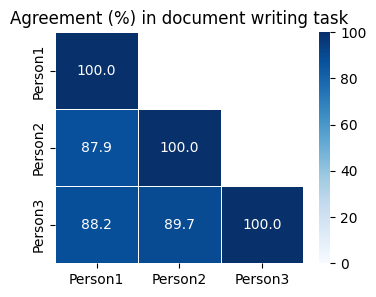

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Converta para np.array para facilitar
avaliadores = [
    np.array(avaliador1, dtype=int),
    np.array(avaliador2, dtype=int),
    np.array(avaliador3, dtype=int)
]

n = len(avaliadores)

# Matriz para guardar a % de concordância
matriz_concordancia = np.zeros((n, n))

# Calcula a % de concordância par a par
for i in range(n):
    for j in range(n):
        iguais = avaliadores[i] == avaliadores[j]
        matriz_concordancia[i, j] = np.mean(iguais) * 100  # porcentagem de acerto

# Converte para DataFrame
df_concordancia = pd.DataFrame(matriz_concordancia,
                               index=[f"Person{i+1}" for i in range(n)],
                               columns=[f"Person{i+1}" for i in range(n)])

# Cria máscara para a parte superior da matriz
mask = np.triu(np.ones_like(df_concordancia, dtype=bool), k=1)

# Plot
plt.figure(figsize=(4, 3))
sns.heatmap(df_concordancia, annot=True, fmt=".1f", cmap="Blues",
            vmin=0, vmax=100, mask=mask, cbar=True, square=False, linewidths=0.5)
plt.title('Agreement (%) in document writing task')
plt.show()


In [ ]:
assert len(avaliador1) == len(avaliador2) == len(avaliador3)

In [ ]:
golden_labels = []
for i in range(len(avaliador1)):
    label = 1 if avaliador1[i]+avaliador2[i]+avaliador3[i] >= 2 else 0
    golden_labels.append(label)

In [ ]:
golden_labels[0:20]

[1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]

In [ ]:
# Remove o campo 'humano' dos três DataFrames
df_h0 = df_human_answers_h0.drop(columns=['humano']).rename(columns={'avaliacao': 'avaliacao_1'})
df_h1 = df_human_answers_h1.drop(columns=['humano']).rename(columns={'avaliacao': 'avaliacao_2'})
df_h2 = df_human_answers_h2.drop(columns=['humano']).rename(columns={'avaliacao': 'avaliacao_3'})

# Faz o merge
df_human_human_answers2 = df_h0.merge(df_h1, on=['exame', 'area', 'numero', 'parte'], how='inner') \
                 .merge(df_h2, on=['exame', 'area', 'numero', 'parte'], how='inner')
for ix, row in df_human_human_answers2.iterrows():
    df_human_human_answers2.at[ix, 'golden_label'] = '1' if int(row['avaliacao_1']) + int(row['avaliacao_2']) + int(row['avaliacao_3']) >= 2 else '0'


In [ ]:
df_human_human_answers2

,exame,area,numero,parte,avaliacao_1,avaliacao_2,avaliacao_3,golden_label
0,39,administrativo,1,I,1,1,1,1
1,39,administrativo,1,II,0,0,0,0
2,39,administrativo,10,I,0,0,0,0
3,39,administrativo,10,II,0,0,0,0
4,39,administrativo,10,III,0,0,0,0
...,...,...,...,...,...,...,...,...
556,41,tributário,7,I,1,1,1,1
557,41,tributário,8,I,1,0,1,1
558,41,tributário,8,II,0,0,0,0
559,41,tributário,9,I,1,1,1,1


Adaptar para funcionar essa bodega

In [ ]:
def corrigir_avaliacao(formated_criteria, evaluation):
    #print('Entrou no corrigir')

    # Remove entradas sem número ou parte
    evaluation = [
        item for item in evaluation
        if item.get('numero') is not None and item.get('parte') is not None
    ]

    # Coleta os pares (numero, parte) que já foram avaliados
    avaliados = {(item['numero'], item['parte']) for item in evaluation}
    #print('Pegou avaliados')

    #faltantes = 0

    for criterio in formated_criteria:
        chave = (criterio['numero'], criterio['parte'])

        if chave not in avaliados:
            novo_item = criterio.copy()
            novo_item['acerto'] = -1
            novo_item['raciocinio'] = 'Critério não avaliado pelo modelo ou falha em representar a estrutura.'
            evaluation.append(novo_item)
            #faltantes += 1
            print(f"[ADICIONADO] Critério {chave} foi incluído com acerto = -1")

    return evaluation


In [ ]:
exams = df_document_writing['exam'].unique()
areas = df_document_writing['area'].unique()
models = df_document_writing['judge_model'].unique()
#models  = ['sabiazinho-3']

df_model_scores = pd.DataFrame(columns=['model','scores'])
df_model_answers = pd.DataFrame(columns=['model','experiment','judge','exam', 'area', 'number', 'parte','evaluation','score'])

last_case =''
last_context = []
try:
    for model in models:

        print(f'Evaluation {model}')
        for experiment in range(0,10):
             for judge in range(0,5):
                exam_score = 0
                for exam in exams:
                    for area in areas:
                        for number in range(1,2):
                            model_scores  = []
                            for ix, row in df_document_writing.query('exam == @exam & area == @area & judge_model == @model  & judge_number == @judge & experiment == @experiment').iterrows():
                                evaluation = row.evaluation
                                if 'resultado' in evaluation:
                                    evaluation = evaluation['resultado']
                                evaluation = corrigir_avaliacao(row.formated_criteria, evaluation)
                                print('---------------')
                                print(f'exp {experiment} judge {judge} exam {exam} number {number}' )

                                last_context = evaluation
                                # treatment to points
                                if 'pontos' not in evaluation[0]: #so the we need to take the scoring points in reference
                                    print('Não tem pontos na avaliação, corrigindo...')
                                    for e in evaluation:
                                        last_case = e
                                        if 'parte' not in e or 'acerto' not in e:
                                            print('Sem parte')
                                            print(z)
                                            continue
                                        print('NUMERO A')
                                        e_numero = e['numero']
                                        e_parte = e['parte']
                                        #now we need to find this question in reference
                                        for c in row.formated_criteria:
                                            print('NUMERO B')
                                            c_numero = c['numero']
                                            c_parte = c['parte']
                                            if e_numero == c_numero and e_parte == c_parte:
                                                #ok, we found the match, so we need to extract the points
                                                print('Corrigido!')
                                                e['pontos'] = c['pontos']
                                for z in evaluation:
                                    last_case = z
                                    print('entrou nas avaliações (caminho normal)')
                                    if 'parte' not in z or 'acerto' not in z:
                                        print('Sem parte ou acerto')
                                        print(z)
                                        continue
                                    print('NUMERO C')

                                    z_numero = z['numero']
                                    z_parte = z['parte']
                                    z_acerto = z['acerto']
                                    if 'pontos'  in z:
                                        z_pontos = z['pontos']
                                    else:
                                        z_pontos = 0
                                    #print(z_letra, z_parte, z_acerto, z_pontos)
                                    print('gravando caso...')
                                    print(f' numero {z_numero} parte {z_parte} acerto {z_acerto} pontos {z_pontos}')
                                    df_model_answers = pd.concat([df_model_answers, pd.DataFrame({'model':[model],'experiment':[experiment],'judge':[judge],'exam':[exam],'area':[area],'number':[z_numero],'parte':[z_parte],'evaluation':[z_acerto],'score':[z_pontos]})], ignore_index=True)
                                    print('gravou caso!')
except Exception as e:
    print('ERRO ',e)


A saída de streaming foi truncada nas últimas 5000 linhas.
gravou caso!
entrou nas avaliações (caminho normal)
NUMERO C
gravando caso...
 numero 2 parte I acerto 1 pontos 0.1
gravou caso!
entrou nas avaliações (caminho normal)
NUMERO C
gravando caso...
 numero 3 parte I acerto 0 pontos 0.1
gravou caso!
entrou nas avaliações (caminho normal)
NUMERO C
gravando caso...
 numero 4 parte I acerto 0 pontos 0.2
gravou caso!
entrou nas avaliações (caminho normal)
NUMERO C
gravando caso...
 numero 5 parte I acerto 0 pontos 0.1
gravou caso!
entrou nas avaliações (caminho normal)
NUMERO C
gravando caso...
 numero 6 parte I acerto 0 pontos 0.1
gravou caso!
entrou nas avaliações (caminho normal)
NUMERO C
gravando caso...
 numero 6 parte II acerto 0 pontos 0.1
gravou caso!
entrou nas avaliações (caminho normal)
NUMERO C
gravando caso...
 numero 7 parte I acerto 0 pontos 0.6
gravou caso!
entrou nas avaliações (caminho normal)
NUMERO C
gravando caso...
 numero 7 parte II acerto 0 pontos 0.1
gravou caso

In [ ]:
df_model_answers.to_pickle('respostas_escrita_peca.pkl')

In [ ]:
print(len(df_model_answers))

197457


In [ ]:
df_model_answers = pd.read_pickle('respostas_escrita_peca.pkl')

In [ ]:
df_model_answers['model'].value_counts()

,count
model,
gpto3-mini,29139
sabiazinho-3,28062
gpt4o-mini,28056
gpt41-mini,28050
gpt4o,28050
gpt41,28050
sabia-3,28050


tratamento

In [ ]:
partes_validas = ['I', 'II', 'III', 'IV', 'V', 'VI','VII','VIII','IX','X']
evaluations_validas = [-1,0,1]
df_model_answers2 = df_model_answers[df_model_answers['parte'].isin(partes_validas)]
df_model_answers2 = df_model_answers2[df_model_answers2['evaluation'].isin(evaluations_validas)]
df_model_answers2.drop_duplicates(['model','experiment','judge','exam','area','number','parte','evaluation'])
df_model_answers2['model'].value_counts()

,count
model,
gpto3-mini,29139
sabiazinho-3,28058
gpt4o-mini,28050
gpt41-mini,28050
gpt4o,28050
gpt41,28050
sabia-3,28050


In [ ]:
import pandas as pd

def fix_df(df, df2):
    """
    Garante que todas as combinações (exam, area, number, parte) presentes em df2 existam no df.
    Se estiver faltando, adiciona entrada no df com evaluation = -1.
    Os campos model, experiment e judge podem ser definidos como padrão ou passados como argumento.
    """
    # Renomeia colunas do df2 para bater com as do df
    model = df.iloc[0].model
    experiment = df.iloc[0].experiment
    judge = df.iloc[0].judge
    df2_renamed = df2.rename(columns={'exame': 'exam', 'numero': 'number'})

    # Colunas de referência
    ref_cols = ['exam', 'area', 'number', 'parte']

    # Gera chaves únicas
    df['key'] = df[ref_cols].astype(str).agg('|'.join, axis=1)
    df2_renamed['key'] = df2_renamed[ref_cols].astype(str).agg('|'.join, axis=1)

    # Identifica chaves do df2 (padrão ouro) que não existem no df (modelo)
    missing_keys = set(df2_renamed['key']) - set(df['key'])

    # Filtra registros faltantes no df
    missing_rows = df2_renamed[df2_renamed['key'].isin(missing_keys)][ref_cols].copy()

    # Adiciona colunas obrigatórias
    missing_rows['model'] = model
    missing_rows['experiment'] = experiment
    missing_rows['judge'] = judge
    missing_rows['evaluation'] = -1

    # Reorganiza colunas no mesmo formato de df
    missing_rows = missing_rows[['model', 'experiment', 'judge', 'exam', 'area', 'number', 'parte', 'evaluation']]

    # Junta com o df original
    df_corrigido = pd.concat([df.drop(columns='key'), missing_rows], ignore_index=True)

    return df_corrigido


In [ ]:
#numero 9

MEXI AQUI

In [ ]:
#antigo
def unifica_dfs(df,df2):
    # Primeiro, renomeie as colunas do df1 para que coincidam com as do df2
    df1_renomeado = df.rename(columns={
        'exam': 'exame',
        'number': 'numero'
    })

    # Agora faça o merge com base nas colunas relevantes
    df_merged = df2.merge(
        df1_renomeado[['exame', 'area', 'numero', 'parte', 'evaluation','score']],
        on=['exame', 'area', 'numero', 'parte'],
        #how='left'
        how='inner'
    )


    # Converta explicitamente os tipos das colunas usadas no merge para garantir correspondência
    df['exam'] = df['exam'].astype(str)
    df['area'] = df['area'].astype(str)
    df['number'] = df['number'].astype(str)
    df['parte'] = df['parte'].astype(str)

    df2['exame'] = df2['exame'].astype(str)
    df2['area'] = df2['area'].astype(str)
    df2['numero'] = df2['numero'].astype(str)
    df2['parte'] = df2['parte'].astype(str)

    # Renomeie para facilitar o merge
    df1_renomeado = df.rename(columns={'exam': 'exame', 'number': 'numero'})

    # Faça o merge
    df_merged = df2.merge(
        df1_renomeado[['exame', 'area', 'numero', 'parte', 'evaluation','score']],
        on=['exame', 'area', 'numero', 'parte'],
        how='inner'
    )

    # Renomeie o campo final
    df_merged = df_merged.rename(columns={'evaluation': 'avaliacao_modelo'})
    df_merged['golden_label'] = df_merged['golden_label'].astype(int)
    df_merged['avaliacao_modelo'] = df_merged['avaliacao_modelo'].astype(int)
    return df_merged

In [ ]:
#antigo
def unifica_dfs_practical(df,df2):
    # Primeiro, renomeie as colunas do df1 para que coincidam com as do df2
    df1_renomeado = df.rename(columns={
        'exam': 'exame',
        'number': 'numero'
    })

    # Agora faça o merge com base nas colunas relevantes
    df_merged = df2.merge(
        df1_renomeado[['exame', 'area', 'numero', 'parte', 'evaluation','score']],
        on=['exame', 'area', 'numero', 'parte'],
        #how='left'
        how='inner'
    )


    # Converta explicitamente os tipos das colunas usadas no merge para garantir correspondência
    df['exam'] = df['exam'].astype(str)
    df['area'] = df['area'].astype(str)
    df['number'] = df['number'].astype(str)
    df['parte'] = df['parte'].astype(str)
    df['experiment'] = df['experiment'].astype(str)
    df['judge'] = df['judge'].astype(str)

    df2['exame'] = df2['exame'].astype(str)
    df2['area'] = df2['area'].astype(str)
    df2['numero'] = df2['numero'].astype(str)
    df2['parte'] = df2['parte'].astype(str)

    # Renomeie para facilitar o merge
    df1_renomeado = df.rename(columns={'exam': 'exame', 'number': 'numero','score': 'potential_score','experiment':'experimento'})

    # Faça o merge
    df_merged = df2.merge(
        df1_renomeado[['model','experimento','judge','exame', 'area', 'numero', 'parte', 'evaluation','potential_score']],
        on=['exame', 'area', 'numero', 'parte'],
        how='inner'
    )

    # Renomeie o campo final
    df_merged = df_merged.rename(columns={'evaluation': 'avaliacao_modelo'})
    df_merged['golden_label'] = df_merged['golden_label'].astype(int)
    df_merged['avaliacao_modelo'] = df_merged['avaliacao_modelo'].astype(int)
    df_merged['score_by_golden_label'] =  df_merged['golden_label'] * df_merged['potential_score']
    df_merged['score_by_model'] =  df_merged['avaliacao_modelo'] * df_merged['potential_score']
    return df_merged

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#antigo
from sklearn.metrics import cohen_kappa_score
experiments = list(range(10))
judges = range(5)
exams = range(39,42)

models = list(df_document_writing['judge_model'].unique())
#models.remove('sabia-3')
#models.remove('sabiazinho-3')
print('Processando')
df_exp2B = pd.DataFrame(columns = ['model','exam','experiment','judge','cohen_kappa','accuracy'])
for model in models:
    for exam in exams:
        for experiment in experiments:
            for judge in judges:
                #print(model, exam, experiment, judge)
                df = df_model_answers2.query('model == @model and judge == @judge and exam == @exam and experiment == @experiment').drop_duplicates()
                exam_s = str(exam)
                df2 = df_human_human_answers2.query('exame == @exam_s ')
                #print(len(df),len(df2))
                #if len(df) != len(df2):
                #    df = fix_df(df,df2)
                #    print('tamanhos diferentes')
                #    if len(df) == 0:
                #        continue
                #print(len(df),len(df2))
                #df_ordered = df.sort_values(by=['exam','area','number','parte'])
                #df2_ordered = df2.sort_values(by=['exame','area','numero','parte'])
                #df_ordered['evaluation'] = df_ordered['evaluation'].astype(str)
                df_merged = unifica_dfs_practical(df,df2)
                accuracy= accuracy_score(df_merged.golden_label, df_merged.avaliacao_modelo)
                cohen_kappa= cohen_kappa_score(df_merged.golden_label, df_merged.avaliacao_modelo)
                #cohen_kappa = cohen_kappa_score(df2_ordered.golden_label, df_ordered.evaluation)
                df_exp2B = pd.concat([df_exp2B,pd.DataFrame({'model':[model], 'exam': [exam], 'experiment': [experiment], 'judge':[judge], 'cohen_kappa':[cohen_kappa],'accuracy':[accuracy]}) ],ignore_index=True)

Processando


In [ ]:
#novo
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr

experiments = list(range(10))
judges = range(5)
exams = range(39,42)
areas = list(df_discursive['area'].unique())
models = list(df_document_writing['judge_model'].unique())

df_all_scores_practical = pd.DataFrame(columns = ['exame', 'area', 'numero',  'parte', 'avaliacao_1',
       'avaliacao_2', 'avaliacao_3', 'golden_label', 'model',
       'avaliacao_modelo', 'potential_score', 'score_by_golden_label','score_by_model'])

#models.remove('sabia-3')
#models.remove('sabiazinho-3')
print('Processando')
#df_exp2B = pd.DataFrame(columns = ['model','exam','experiment','judge','cohen_kappa','accuracy'])
df_exp2B = pd.DataFrame(columns = ['model','exam','experiment','judge','cohen_kappa','accuracy','score_spearman_corr','score_spearman_p','score_pearson_corr','score_pearson_p','score_mae'])
df_exp3B = pd.DataFrame(columns = ['model','exam','experiment','judge','area','cohen_kappa','accuracy'])

for model in models:
    print(model)
    for exam in exams:
        for experiment in experiments:
            for judge in judges:
                #print(model, exam, experiment, judge)
                df = df_model_answers2.query('model == @model and judge == @judge and exam == @exam and experiment == @experiment').drop_duplicates()
                exam_s = str(exam)
                df2 = df_human_human_answers2.query('exame == @exam_s ')
                #print(f'DF1 {df.columns}\n DF2 {df2.columns}' )
                #print(len(df),len(df2))
                #if len(df) != len(df2):
                #    df = fix_df(df,df2)
                #    print('tamanhos diferentes')
                #    if len(df) == 0:
                #        continue
                #print(len(df),len(df2))
                #df_ordered = df.sort_values(by=['exam','area','number','parte'])
                #df2_ordered = df2.sort_values(by=['exame','area','numero','parte'])
                #df_ordered['evaluation'] = df_ordered['evaluation'].astype(str)
                df_merged = unifica_dfs_practical(df,df2)
                df_all_scores_practical = pd.concat([df_all_scores_practical, df_merged],ignore_index=True)
                accuracy= accuracy_score(df_merged.golden_label, df_merged.avaliacao_modelo)
                cohen_kappa= cohen_kappa_score(df_merged.golden_label, df_merged.avaliacao_modelo)
                pearson_corr, pearson_p = pearsonr(df_merged['score_by_golden_label'], df_merged['score_by_model'])
                spearman_corr, spearman_p = spearmanr(df_merged['score_by_golden_label'], df_merged['score_by_model'])
                score_mae = mean_absolute_error(df_merged['score_by_golden_label'], df_merged['score_by_model'])

                #cohen_kappa = cohen_kappa_score(df2_ordered.golden_label, df_ordered.evaluation)
                #df_exp2B = pd.concat([df_exp2B,pd.DataFrame({'model':[model], 'exam': [exam], 'experiment': [experiment], 'judge':[judge], 'cohen_kappa':[cohen_kappa],'accuracy':[accuracy]}) ],ignore_index=True)
                df_exp2B = pd.concat([df_exp2B,pd.DataFrame({'model':[model], 'exam': [exam], 'experiment': [experiment], 'judge':[judge], 'cohen_kappa':[cohen_kappa],'accuracy':[accuracy],
                'score_spearman_corr': [spearman_corr],'score_spearman_p': [spearman_p],
                'score_pearson_corr': [pearson_corr], 'score_pearson_p': [pearson_p],
                'score_mae': [score_mae]}) ],ignore_index=True)
                for area in areas:
                    df_practical_area = df_merged.query("area == @area")
                    accuracy_area= accuracy_score(df_practical_area.golden_label, df_practical_area.avaliacao_modelo)
                    cohen_kappa_area = cohen_kappa_score( df_practical_area.golden_label,  df_practical_area.avaliacao_modelo)
                    pearson_corr, pearson_p = pearsonr(df_practical_area['score_by_golden_label'], df_practical_area['score_by_model'])
                    spearman_corr, spearman_p = spearmanr(df_practical_area['score_by_golden_label'], df_practical_area['score_by_model'])
                    score_mae = mean_absolute_error(df_practical_area['score_by_golden_label'], df_practical_area['score_by_model'])
                    df_exp3B = pd.concat([df_exp3B,pd.DataFrame({'model':[model], 'exam': [exam], 'experiment': [experiment], 'judge':[judge],'area':[area], 'cohen_kappa':[cohen_kappa_area],'accuracy':[accuracy_area],
                    'score_spearman_corr': [spearman_corr],'score_spearman_p': [spearman_p],
                    'score_pearson_corr': [pearson_corr], 'score_pearson_p': [pearson_p],
                    'score_mae': [score_mae]}) ],ignore_index=True)

Processando
gpt4o-mini
gpt4o
gpt41-mini
gpt41
sabiazinho-3
sabia-3
gpto3-mini


In [ ]:
df_practical_scores = pd.DataFrame(columns=['model','exame','area','experimento','judge','score_by_golden_label', 'score_by_model','normalized_score_by_golden_label','normalized_score_by_model'])
all = df_all_scores_practical.groupby(['model','exame','area','experimento','judge'])[['score_by_golden_label', 'score_by_model']].sum()
for index, row in all.iterrows():
    model, exame, area, experimento, judge = index  # descompacta os índices do grupo
    score_golden = row['score_by_golden_label']
    score_model = row['score_by_model']
    normalized_score_golden = score_golden *20
    normalized_score_model = score_golden *20
    df_practical_scores = pd.concat([df_practical_scores, pd.DataFrame([{
    'model': model,
    'exame': exame,
    'area': area,
    'experimento': experimento,
    'judge': judge,
    'score_by_golden_label': score_golden,
    'score_by_model': score_model,
    'normalized_score_by_golden_label': score_golden *20,
    'normalized_score_by_model': score_model *20
}])], ignore_index=True)


In [ ]:
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import pandas as pd

# DataFrame de saída
df_metricas_practical = pd.DataFrame(columns=[
    'model', 'area', 'experimento',
    'mae_normalized',
    'pearson_corr', 'pearson_pvalue',
    'spearman_corr', 'spearman_pvalue'
])

# Agrupamento por model, area, experimento
agrupado = df_practical_scores.groupby(['model', 'area', 'experimento'])

for (model, area, experimento), grupo in agrupado:
    # Extrai os vetores normalizados
    golden_scores = grupo['normalized_score_by_golden_label'].astype(float)
    model_scores = grupo['normalized_score_by_model'].astype(float)

    # Calcula as métricas
    mae = mean_absolute_error(golden_scores, model_scores)
    pearson_corr, pearson_p = pearsonr(golden_scores, model_scores)
    spearman_corr, spearman_p = spearmanr(golden_scores, model_scores)

    # Adiciona à tabela de resultados
    df_metricas_practical = pd.concat([df_metricas_practical, pd.DataFrame([{
        'model': model,
        'area': area,
        'experimento': experimento,
        'mae_normalized': mae,
        'pearson_corr': pearson_corr,
        'pearson_pvalue': pearson_p,
        'spearman_corr': spearman_corr,
        'spearman_pvalue': spearman_p
    }])], ignore_index=True)

In [ ]:
df_objective = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/avaliation/respostas_objetivas_com_area.pkl')

In [ ]:
def first_phase_score_area(df,area,model, exam):
    print(area, model)
    areas = dict_areas[area]

    df_area = df.query("area in @areas and model == @model and exam == @exam  ")
    qtd = len(df_area)
    print(qtd)
    acertos = len(df_area.query("model_answer == answer"))
    score = acertos/qtd *100
    return round(score,2)


In [ ]:
def target_score_area(df,area, model, exam):
    exam= str(exam)
    df_area = df.query("area == @area  and model == @model and exame == @exam ")
    score = df_area['normalized_score_by_golden_label'].mean()
    return round(score,2)

In [ ]:
def second_phase_score_area(df,area, model, exam):

    exam= str(exam)
    df_area = df.query("area == @area and model == @model and  exame == @exam ")
    score = df_area['normalized_score_by_model'].mean()
    return round(score,2)

In [ ]:
dict_areas =  {'civil': ['civil','processo sivil'],
               'penal': ['penal','processo penal'],
               'trabalhista' : ['trabalho','processo do trabalho'],
               'tributário': ['tributario'],
               'administrativo': ['administrativo'],
               'constitucional': ['constitucional'],
               'empresarial': ['empresarial']
               }

In [ ]:
dict_models = {'gpt4o':'gpt_4o', 'gpt4o-mini':  'gpt_4o_mini', 'gpto3-mini':'gpt_o3_mini',  'sabiazinho-3' :'sabiazinho3','sabia-3' : 'sabia3', 'gpt41': 'gpt_41', 'gpt41-mini':   'gpt_41_mini'    }

In [ ]:
df_proxy_experiment_practical = pd.DataFrame(columns=['model','exam','area','first_phase','document_writing','target'])
exames = [e for e in  list(df_objective['exam'].unique()) if e in list(df_document_writing['exam'].unique())]
print(exames)
for area in list(df_document_writing['area'].unique()):
    for model in list(df_document_writing['judge_model'].unique()):
        for exame in exames:
            print(model, area)
            print(dict_models[model])
            first_phase = first_phase_score_area(df_objective,area,dict_models[model], exame)
            second_phase = second_phase_score_area(df_practical_scores ,area,model, exame)
            target = target_score_area(df_practical_scores ,area,model, exame)
            df_proxy_experiment_practical = pd.concat([df_proxy_experiment_practical, pd.DataFrame({'model': [model],'exam': [exame],'area':[area], 'first_phase': [first_phase], 'document_writing': [second_phase], 'target': [target]})],ignore_index=True)
df_proxy_experiment_practical.sample(3)

[41, 40]
gpt4o-mini administrativo
gpt_4o_mini
administrativo gpt_4o_mini
5
gpt4o-mini administrativo
gpt_4o_mini
administrativo gpt_4o_mini
5
gpt4o administrativo
gpt_4o
administrativo gpt_4o
5
gpt4o administrativo
gpt_4o
administrativo gpt_4o
5
gpt41-mini administrativo
gpt_41_mini
administrativo gpt_41_mini
5
gpt41-mini administrativo
gpt_41_mini
administrativo gpt_41_mini
5
gpt41 administrativo
gpt_41
administrativo gpt_41
5
gpt41 administrativo
gpt_41
administrativo gpt_41
5
sabiazinho-3 administrativo
sabiazinho3
administrativo sabiazinho3
5
sabiazinho-3 administrativo
sabiazinho3
administrativo sabiazinho3
5
sabia-3 administrativo
sabia3
administrativo sabia3
5
sabia-3 administrativo
sabia3
administrativo sabia3
5
gpto3-mini administrativo
gpt_o3_mini
administrativo gpt_o3_mini
5
gpto3-mini administrativo
gpt_o3_mini
administrativo gpt_o3_mini
5
gpt4o-mini civil
gpt_4o_mini
civil gpt_4o_mini
6
gpt4o-mini civil
gpt_4o_mini
civil gpt_4o_mini
6
gpt4o civil
gpt_4o
civil gpt_4o
6
gpt

,model,exam,area,first_phase,document_writing,target
34,gpt41,41,constitucional,83.33,43.24,34.00
52,sabia-3,41,empresarial,100.00,88.16,57.00
36,sabiazinho-3,41,constitucional,66.67,42.72,28.68


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression
from pingouin import intraclass_corr

# DataFrame final com area incluída
df_proxy_experiment_practical_scores = pd.DataFrame(columns=[
    'model', 'area',
    'mean_first_phase', 'mean_document_writing', 'mean_target',
    'mae_first_phase', 'mae_document_writing',
    'rmse_first_phase', 'rmse_document_writing',

])


# Iteração por modelo e área
for (model, area), group in df_proxy_experiment_practical.groupby(['model', 'area']):
    x1 = group['first_phase'].values.reshape(-1, 1)
    x2 = group['document_writing'].values.reshape(-1, 1)
    y = group['target'].values


    df_proxy_experiment_practical_scores = pd.concat([df_proxy_experiment_practical_scores, pd.DataFrame({
        'model': [model],
        'area': [area],
        'mean_first_phase': [round(np.mean(group['first_phase']),2)],
        'mean_document_writing': [round(np.mean(group['document_writing']),2)],
        'mean_target': [round(np.mean(group['target']),2)],
        'mae_first_phase': [round(mean_absolute_error(y, group['first_phase']),2)],
        'mae_document_writing': [round(mean_absolute_error(y, group['document_writing']),2)],
        'rmse_first_phase': [round(np.sqrt(mean_squared_error(y, group['first_phase'])),2)],
        'rmse_document_writing': [round(np.sqrt(mean_squared_error(y, group['document_writing'])),2)],
    })], ignore_index=True)
    #print(round(np.sqrt(mean_squared_error(y, group['first_phase'])),2))


In [ ]:
df_proxy_experiment_practical_scores.groupby(['model'])[['mean_first_phase','mean_document_writing','mean_target','mae_first_phase','mae_document_writing','rmse_first_phase','rmse_document_writing']].mean()

,mean_first_phase,mean_document_writing,mean_target,mae_first_phase,mae_document_writing,rmse_first_phase,rmse_document_writing
model,,,,,,,
gpt41,70.715714,57.580000,43.142857,32.715714,15.077143,36.152857,17.905714
gpt41-mini,79.761429,57.597143,43.142857,36.618571,15.157143,38.000000,17.977143
gpt4o,85.475714,53.821429,43.142857,42.332857,13.507143,44.347143,15.202857
gpt4o-mini,64.642857,60.462857,43.142857,25.071429,18.714286,26.381429,20.107143
gpto3-mini,66.072857,36.798571,44.360000,26.278571,13.530000,27.811429,15.897143
sabia-3,76.428571,65.147143,43.142857,35.857143,34.010000,37.587143,37.697143
sabiazinho-3,69.287143,36.155714,42.668571,27.618571,32.878571,28.864286,39.197143


In [ ]:
df_proxy_experiment_practical_scores.query('model == "gpt4o"')

,model,area,mean_first_phase,mean_document_writing,mean_target,mae_first_phase,mae_document_writing,rmse_first_phase,rmse_document_writing
14,gpt4o,administrativo,90.00,65.82,31.0,59.00,34.82,59.21,35.44
15,gpt4o,civil,75.00,68.01,47.5,27.50,20.51,37.73,24.89
16,gpt4o,constitucional,75.00,48.74,37.0,38.00,13.14,38.37,17.62
17,gpt4o,empresarial,100.00,45.95,50.0,50.00,6.23,50.49,7.43
18,gpt4o,penal,83.33,43.93,40.5,42.83,3.43,42.83,3.82
19,gpt4o,trabalhista,85.00,40.46,38.0,47.00,10.58,48.27,10.86
20,gpt4o,tributário,90.00,63.84,58.0,32.00,5.84,33.53,6.36


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut

# DataFrame de saída para armazenar os resultados da validação cruzada
df_proxy_experiment_practical_scores_cv_univariate_regression = pd.DataFrame(columns=[
    'model',
    'r2_first_phase', 'r2_document_writing',
    'coef_first_phase_mean', 'coef_document_writing_mean',
    'mae_first_phase_mean', 'mae_document_writing_mean',
    'rmse_first_phase_mean', 'rmse_document_writing_mean',
    'coef_first_phase_std', 'coef_document_writing_std'
])

# Itera por modelo
for model, group in df_proxy_experiment_practical_scores.groupby('model'):
    if len(group) < 2: continue # Pula se não for possível fazer a validação

    x1 = group['mean_first_phase'].values.reshape(-1, 1)
    x2 = group['mean_document_writing'].values.reshape(-1, 1)
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # --- Processamento para a primeira feature (x1: first_phase) ---
    y_true_all_1, y_pred_all_1 = [], []
    scores1_mae, scores1_rmse, coefs1 = [], [], []

    for train_index, test_index in loo.split(x1):
        x1_train, x1_test = x1[train_index], x1[test_index]
        y_train, y_test = y[train_index], y[test_index]

        reg1 = LinearRegression().fit(x1_train, y_train)
        y_pred1 = reg1.predict(x1_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all_1.extend(y_test)
        y_pred_all_1.extend(y_pred1)
        coefs1.append(reg1.coef_[0])
        scores1_mae.append(mean_absolute_error(y_test, y_pred1))
        scores1_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred1)))

    # Calcula o R² geral e as médias DEPOIS que o loop terminar
    r2_overall_1 = r2_score(y_true_all_1, y_pred_all_1)


    # --- Processamento para a segunda feature (x2: document_writing) ---
    y_true_all_2, y_pred_all_2 = [], []
    scores2_mae, scores2_rmse, coefs2 = [], [], []

    for train_index, test_index in loo.split(x2):
        x2_train, x2_test = x2[train_index], x2[test_index]
        y_train, y_test = y[train_index], y[test_index]

        reg2 = LinearRegression().fit(x2_train, y_train)
        y_pred2 = reg2.predict(x2_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all_2.extend(y_test)
        y_pred_all_2.extend(y_pred2)
        coefs2.append(reg2.coef_[0])
        scores2_mae.append(mean_absolute_error(y_test, y_pred2))
        scores2_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred2)))

    # Calcula o R² geral e as médias DEPOIS que o loop terminar
    r2_overall_2 = r2_score(y_true_all_2, y_pred_all_2)


    # Adiciona os resultados robustos ao DataFrame
    df_proxy_experiment_practical_scores_cv_univariate_regression = pd.concat([df_proxy_experiment_practical_scores_cv_univariate_regression, pd.DataFrame({
        'model': [model],
        'r2_first_phase': [r2_overall_1],
        'r2_document_writing': [r2_overall_2],
        'coef_first_phase_mean': [np.mean(coefs1)],
        'coef_document_writing_mean': [np.mean(coefs2)],
        'mae_first_phase_mean': [np.mean(scores1_mae)],
        'mae_document_writing_mean': [np.mean(scores2_mae)],
        'rmse_first_phase_mean': [np.mean(scores1_rmse)],
        'rmse_document_writing_mean': [np.mean(scores2_rmse)],
        'coef_first_phase_std': [np.std(coefs1)],
        'coef_document_writing_std': [np.std(coefs2)],
    })], ignore_index=True)

In [ ]:
df_proxy_experiment_practical_scores_cv_univariate_regression

,model,r2_first_phase,r2_document_writing,coef_first_phase_mean,coef_document_writing_mean,mae_first_phase_mean,mae_document_writing_mean,rmse_first_phase_mean,rmse_document_writing_mean,coef_first_phase_std,coef_document_writing_std
0,gpt41,-0.663052,-0.779544,-0.356809,0.333543,9.681199,8.987354,9.681199,8.987354,0.181199,0.206096
1,gpt41-mini,-1.062514,-0.694352,-0.317645,0.353969,11.299644,8.838703,11.299644,8.838703,0.217134,0.193934
2,gpt4o,-0.571168,-0.862198,0.282772,0.169521,9.211845,9.251511,9.211845,9.251511,0.154044,0.153945
3,gpt4o-mini,-0.333579,0.224384,-0.529260,0.422446,9.308830,6.468687,9.308830,6.468687,0.167684,0.062978
4,gpto3-mini,0.121438,-0.639139,-0.634390,0.552810,6.773610,8.443957,6.773610,8.443957,0.112807,0.215401
5,sabia-3,0.014708,-0.994674,-0.466589,0.034360,8.004061,10.852292,8.004061,10.852292,0.091511,0.081680
6,sabiazinho-3,0.029170,-0.836726,-0.928838,-0.004340,7.019455,10.943153,7.019455,10.943153,0.184797,0.050173


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut

# DataFrame de saída para armazenar os resultados da validação cruzada
df_proxy_experiment_practical_scores_cv_random_regression = pd.DataFrame(columns=[
    'model',
    'r2_first_phase', 'r2_document_writing',
    'mae_first_phase_mean', 'mae_document_writing_mean',
    'rmse_first_phase_mean', 'rmse_document_writing_mean'
])

# Itera por modelo
for model, group in df_proxy_experiment_practical_scores.groupby('model'):
    if len(group) < 2: continue # Pula se não for possível fazer a validação

    x1 = group['mean_first_phase'].values.reshape(-1, 1)
    x2 = group['mean_document_writing'].values.reshape(-1, 1)
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # --- Processamento para a primeira feature (x1: first_phase) ---
    y_true_all_1, y_pred_all_1 = [], []
    scores1_mae, scores1_rmse = [], []

    for train_index, test_index in loo.split(x1):
        x1_train, x1_test = x1[train_index], x1[test_index]
        y_train, y_test = y[train_index], y[test_index]

        reg1 = RandomForestRegressor(random_state=42).fit(x1_train, y_train)
        y_pred1 = reg1.predict(x1_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all_1.extend(y_test)
        y_pred_all_1.extend(y_pred1)
        scores1_mae.append(mean_absolute_error(y_test, y_pred1))
        scores1_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred1)))

    # Calcula o R² geral e as médias DEPOIS que o loop terminar
    r2_overall_1 = r2_score(y_true_all_1, y_pred_all_1)


    # --- Processamento para a segunda feature (x2: document_writing) ---
    y_true_all_2, y_pred_all_2 = [], []
    scores2_mae, scores2_rmse = [], []

    for train_index, test_index in loo.split(x2):
        x2_train, x2_test = x2[train_index], x2[test_index]
        y_train, y_test = y[train_index], y[test_index]

        reg2 = RandomForestRegressor(random_state=42).fit(x2_train, y_train)
        y_pred2 = reg2.predict(x2_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all_2.extend(y_test)
        y_pred_all_2.extend(y_pred2)
        scores2_mae.append(mean_absolute_error(y_test, y_pred2))
        scores2_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred2)))

    # Calcula o R² geral e as médias DEPOIS que o loop terminar
    r2_overall_2 = r2_score(y_true_all_2, y_pred_all_2)


    # Adiciona os resultados robustos ao DataFrame
    df_proxy_experiment_practical_scores_cv_random_regression = pd.concat([df_proxy_experiment_practical_scores_cv_random_regression, pd.DataFrame({
        'model': [model],
        'r2_first_phase': [r2_overall_1],
        'r2_document_writing': [r2_overall_2],
        'mae_first_phase_mean': [np.mean(scores1_mae)],
        'mae_document_writing_mean': [np.mean(scores2_mae)],
        'rmse_first_phase_mean': [np.mean(scores1_rmse)],
        'rmse_document_writing_mean': [np.mean(scores2_rmse)],
    })], ignore_index=True)

In [ ]:
df_proxy_experiment_practical_scores_cv_random_regression

,model,r2_first_phase,r2_document_writing,mae_first_phase_mean,mae_document_writing_mean,rmse_first_phase_mean,rmse_document_writing_mean
0,gpt41,-0.777358,-0.497366,9.756786,6.999286,9.756786,6.999286
1,gpt41-mini,-0.997090,-0.485088,10.403571,6.953571,10.403571,6.953571
2,gpt4o,-1.464130,-1.737935,10.525357,12.173571,10.525357,12.173571
3,gpt4o-mini,-0.861946,0.310641,10.336429,5.979286,10.336429,5.979286
4,gpto3-mini,-0.283148,-0.062181,6.980347,7.116943,6.980347,7.116943
5,sabia-3,-0.798077,-1.006149,10.539238,9.633571,10.539238,9.633571
6,sabiazinho-3,0.080361,-1.742107,6.572771,12.622429,6.572771,12.622429


In [ ]:
# --- SEU CÓDIGO ATÉ A COMBINAÇÃO (ESTÁ CORRETO) ---
df_rf_uni = df_proxy_experiment_practical_scores_cv_random_regression.copy()
df_rf_uni['algorithm'] = 'Random Forest'

df_lr_uni = df_proxy_experiment_practical_scores_cv_univariate_regression.copy()
df_lr_uni['algorithm'] = 'Regressão Linear'

df_combined_uni = pd.concat([df_rf_uni, df_lr_uni], ignore_index=True)


# --- PASSO DE CORREÇÃO: PADRONIZAR TODOS OS NOMES DAS COLUNAS ---
# Adicionamos as regras para 'document_writing' aqui
df_combined_uni.rename(columns={
    'mae_first_phase_mean': 'mae_first_phase',
    'rmse_first_phase_mean': 'rmse_first_phase',
    'mae_document_writing_mean': 'mae_document_writing',     # <-- ADICIONADO
    'rmse_document_writing_mean': 'rmse_document_writing',   # <-- ADICIONADO
    'mae_discursive_mean': 'mae_discursive',                 # (Mantido caso use em outro lugar)
    'rmse_discursive_mean': 'rmse_discursive'                # (Mantido caso use em outro lugar)
}, inplace=True)

# -------------------------------------------------------------

# 3. Reestruturar o DataFrame para o formato "longo" (AGORA VAI FUNCIONAR)
df_long = pd.wide_to_long(
    df_combined_uni,
    stubnames=['r2', 'mae', 'rmse'],
    i=['model', 'algorithm'],
    j='feature',
    sep='_',
    suffix='\\w+'
).reset_index()

# 4. Renomear os valores da coluna 'feature' para maior clareza
# Adicionamos a regra para 'document_writing'
df_long['feature'] = df_long['feature'].replace({
    'first_phase': 'Apenas 1ª Fase',
    'document_writing': 'Apenas Redação' # <-- ADICIONADO/AJUSTADO
})

# 5. Criar a tabela com os eixos INTERCALADOS
interleaved_table = df_long.pivot_table(
    index=['feature', 'algorithm'],
    columns='model',
    values=['r2', 'mae', 'rmse']
)

# 6. Reordenar as colunas para agrupar por métrica
interleaved_table = interleaved_table.swaplevel(0, 1, axis=1).sort_index(axis=1)

# 7. Exibir a tabela final com estilização
print("--- Tabela Comparativa Intercalada (Fase > Algoritmo ML) ---")

mae_rmse_cols = [col for col in interleaved_table.columns if col[0] in ['mae', 'rmse']]
r2_cols = [col for col in interleaved_table.columns if col[0] == 'r2']

styled_interleaved_table = interleaved_table.style.format("{:.3f}").background_gradient(
    cmap='viridis_r', subset=mae_rmse_cols
).background_gradient(
    cmap='viridis', subset=r2_cols
)

styled_interleaved_table

--- Tabela Comparativa Intercalada (Fase > Algoritmo ML) ---


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut

# DataFrame de saída para armazenar os resultados da validação cruzada
df_proxy_experiment_practical_scores_cv_bivariate_regression = pd.DataFrame(columns=[
    'model',
    'r2_combined',
    'mae_combined_mean', 'rmse_combined_mean',
    'coef_first_phase_mean', 'coef_document_writing_mean',
    'coef_first_phase_std', 'coef_document_writing_std'
])

# Itera por modelo
for model, group in df_proxy_experiment_practical_scores.groupby('model'):
    if len(group) < 2: continue # Pula se não for possível fazer a validação

    # Features combinadas: primeira e segunda fase
    X = group[['mean_first_phase', 'mean_document_writing']].values
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # Listas para armazenar os resultados de cada iteração (fold)
    y_true_all, y_pred_all = [], []
    scores_mae, scores_rmse = [], []
    coefs_first_phase, coefs_document_writing = [], [] # Listas separadas para cada coeficiente

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Instancia e treina o modelo de regressão múltipla
        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        scores_mae.append(mean_absolute_error(y_test, y_pred))
        scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

        # Armazena os dois coeficientes separadamente
        coefs_first_phase.append(reg.coef_[0])
        coefs_document_writing.append(reg.coef_[1])

    # Calcula as métricas agregadas DEPOIS que o loop terminar
    r2_overall = r2_score(y_true_all, y_pred_all)


    # Adiciona os resultados robustos ao DataFrame
    df_proxy_experiment_practical_scores_cv_bivariate_regression = pd.concat([df_proxy_experiment_practical_scores_cv_bivariate_regression, pd.DataFrame({
        'model': [model],
        'r2_combined': [r2_overall],
        'mae_combined_mean': [np.mean(scores_mae)],
        'rmse_combined_mean': [np.mean(scores_rmse)],
        'coef_first_phase_mean': [np.mean(coefs_first_phase)],
        'coef_document_writing_mean': [np.mean(coefs_document_writing)],
        'coef_first_phase_std': [np.std(coefs_first_phase)],
        'coef_document_writing_std': [np.std(coefs_document_writing)],
    })], ignore_index=True)

In [ ]:
df_proxy_experiment_practical_scores_cv_bivariate_regression

,model,r2_combined,mae_combined_mean,rmse_combined_mean,coef_first_phase_mean,coef_document_writing_mean,coef_first_phase_std,coef_document_writing_std
0,gpt41,-2.072862,12.263311,12.263311,-0.298470,0.052652,0.253802,0.193831
1,gpt41-mini,-5.196653,15.101327,15.101327,-0.195574,0.204083,0.443958,0.445242
2,gpt4o,-1.434298,10.167855,10.167855,0.321846,0.202108,0.200334,0.197281
3,gpt4o-mini,0.356663,6.110435,6.110435,-0.434106,0.364077,0.123354,0.048802
4,gpto3-mini,0.037742,6.873347,6.873347,-0.537337,0.460992,0.121114,0.177822
5,sabia-3,-0.663322,9.936017,9.936017,-0.502409,-0.028192,0.087118,0.087197
6,sabiazinho-3,-0.389563,8.668187,8.668187,-0.965616,0.038646,0.230242,0.048220


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import LeaveOneOut

# DataFrame de saída para armazenar os resultados da validação cruzada
df_proxy_experiment_practical_scores_cv_random_regression_multi = pd.DataFrame(columns=[
    'model',
    'r2_combined',
    'mae_combined_mean', 'rmse_combined_mean'
])

# Itera por modelo
for model, group in df_proxy_experiment_practical_scores.groupby('model'):
    if len(group) < 2: continue # Pula se não for possível fazer a validação

    # Features combinadas: primeira e segunda fase
    X = group[['mean_first_phase', 'mean_document_writing']].values
    y = group['mean_target'].values

    loo = LeaveOneOut()

    # Listas para armazenar os resultados de cada iteração
    y_true_all, y_pred_all = [], []
    scores_mae, scores_rmse = [], []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Instancia e treina o modelo RandomForestRegressor
        reg = RandomForestRegressor(random_state=42).fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        # Coleta os resultados para cálculos pós-loop
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        scores_mae.append(mean_absolute_error(y_test, y_pred))
        scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # Calcula as métricas agregadas DEPOIS que o loop terminar
    r2_overall = r2_score(y_true_all, y_pred_all)


    # Adiciona os resultados robustos ao DataFrame
    df_proxy_experiment_practical_scores_cv_random_regression_multi = pd.concat([df_proxy_experiment_practical_scores_cv_random_regression_multi, pd.DataFrame({
        'model': [model],
        'r2_combined': [r2_overall],
        'mae_combined_mean': [np.mean(scores_mae)],
        'rmse_combined_mean': [np.mean(scores_rmse)],
    })], ignore_index=True)

In [ ]:
df_proxy_experiment_practical_scores_cv_random_regression_multi

,model,r2_combined,mae_combined_mean,rmse_combined_mean
0,gpt41,-0.699010,8.662143,8.662143
1,gpt41-mini,-0.836978,8.885714,8.885714
2,gpt4o,-1.664600,11.480714,11.480714
3,gpt4o-mini,0.419895,4.807857,4.807857
4,gpto3-mini,0.080211,7.126857,7.126857
5,sabia-3,-0.855116,10.752857,10.752857
6,sabiazinho-3,-0.307132,7.965429,7.965429


In [ ]:
# --- SEU CÓDIGO ATÉ A COMBINAÇÃO (ESTÁ CORRETO) ---
# (Assumindo que os DataFrames corretos estão sendo carregados)
df_rf_multi = df_proxy_experiment_practical_scores_cv_random_regression_multi.copy()
df_rf_multi['algorithm'] = 'Random Forest'

df_lr_multi = df_proxy_experiment_practical_scores_cv_bivariate_regression.copy()
df_lr_multi['algorithm'] = 'Regressão Linear'

df_combined_multi = pd.concat([df_rf_multi, df_lr_multi], ignore_index=True)


# --- PASSO DE CORREÇÃO: PADRONIZAR OS NOMES DAS COLUNAS 'COMBINED' ---
df_combined_multi.rename(columns={
    'mae_combined_mean': 'mae_combined',
    'rmse_combined_mean': 'rmse_combined'
}, inplace=True)

# -------------------------------------------------------------

# 3. Reestruturar o DataFrame para o formato "longo" (AGORA VAI FUNCIONAR)
df_long = pd.wide_to_long(
    df_combined_multi,
    stubnames=['r2', 'mae', 'rmse'],
    i=['model', 'algorithm'],
    j='feature',
    sep='_',
    suffix='\\w+' # A expressão regular ainda funciona bem aqui
).reset_index()

# 4. Renomear os valores da coluna 'feature' para maior clareza
# CORREÇÃO AQUI: o nome da feature agora é 'combined'
df_long['feature'] = df_long['feature'].replace({
    'combined': 'Features Combinadas'
})

# 5. Criar a tabela com os eixos INTERCALADOS
interleaved_table = df_long.pivot_table(
    index=['feature', 'algorithm'],
    columns='model',
    values=['r2', 'mae', 'rmse']
)

# 6. Reordenar as colunas para agrupar por métrica
interleaved_table = interleaved_table.swaplevel(0, 1, axis=1).sort_index(axis=1)

# 7. Exibir a tabela final com estilização
print("--- Tabela Comparativa Intercalada (Features Combinadas) ---")

mae_rmse_cols = [col for col in interleaved_table.columns if col[0] in ['mae', 'rmse']]
r2_cols = [col for col in interleaved_table.columns if col[0] == 'r2']

styled_interleaved_table = interleaved_table.style.format("{:.3f}").background_gradient(
    cmap='viridis_r', subset=mae_rmse_cols
).background_gradient(
    cmap='viridis', subset=r2_cols
)

styled_interleaved_table

--- Tabela Comparativa Intercalada (Features Combinadas) ---


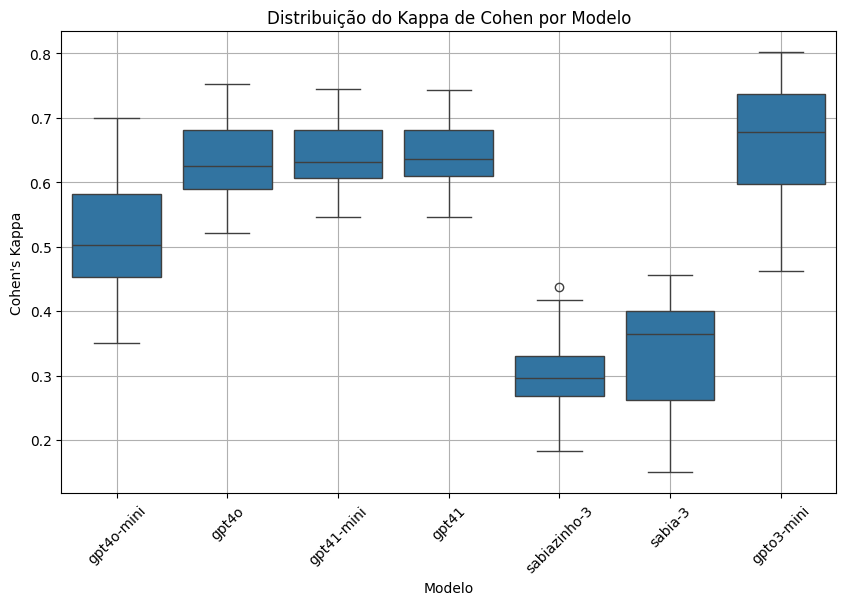

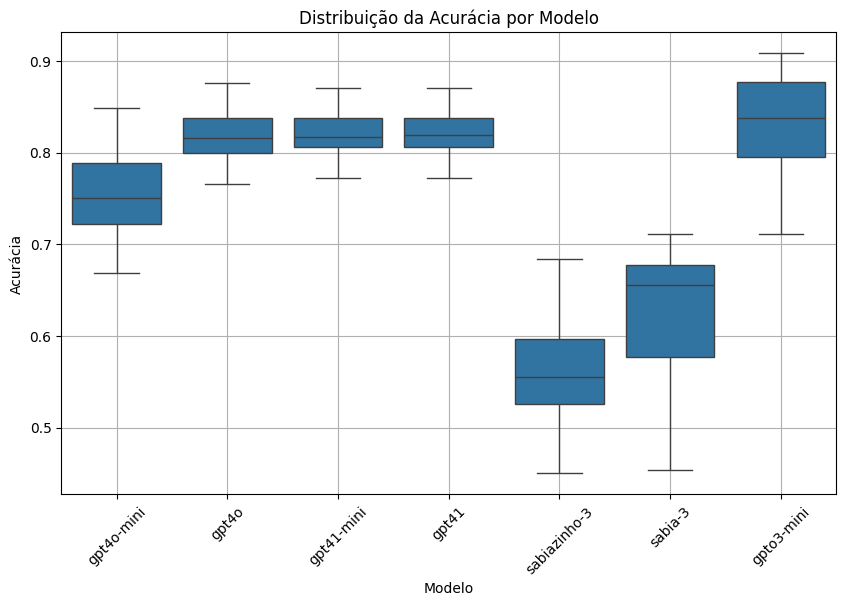

Resumo Estatístico do Cohen's Kappa:


,Média,Mediana,Desvio Padrão,IC95% Inferior,IC95% Superior
model,,,,,
gpt41,0.643468,0.636216,0.043984,0.636371,0.650564
gpt41-mini,0.643213,0.631832,0.046452,0.635718,0.650708
gpt4o,0.637764,0.624999,0.059519,0.628162,0.647367
gpt4o-mini,0.511477,0.502576,0.077765,0.498930,0.524023
gpto3-mini,0.665356,0.677593,0.082879,0.651984,0.678727
sabia-3,0.335831,0.364374,0.080287,0.322877,0.348785
sabiazinho-3,0.303303,0.296176,0.051598,0.294979,0.311628



Resumo Estatístico da Acurácia:


,Média,Mediana,Desvio Padrão,IC95% Inferior,IC95% Superior
model,,,,,
gpt41,0.821585,0.819048,0.021093,0.818181,0.824988
gpt41-mini,0.821396,0.816667,0.022271,0.817802,0.824989
gpt4o,0.820346,0.816271,0.027385,0.815928,0.824765
gpt4o-mini,0.752736,0.750000,0.040265,0.746239,0.759232
gpto3-mini,0.832245,0.837304,0.050176,0.824150,0.840341
sabia-3,0.623648,0.655556,0.072313,0.611981,0.635316
sabiazinho-3,0.558100,0.555556,0.051488,0.549793,0.566407


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st



# Boxplot do Cohen's Kappa
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exp2B, x='model', y='cohen_kappa')
plt.title("Distribuição do Kappa de Cohen por Modelo")
plt.ylabel("Cohen's Kappa")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Boxplot da Acurácia
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exp2B, x='model', y='accuracy')
plt.title("Distribuição da Acurácia por Modelo")
plt.ylabel("Acurácia")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Agora média, desvio padrão e IC95%
def resumo_estatistico(coluna):
    media = coluna.mean()
    desvio = coluna.std()
    mediana = coluna.median()
    n = len(coluna)
    erro_padrao = desvio / (n ** 0.5)
    intervalo = st.t.interval(0.95, n-1, loc=media, scale=erro_padrao)
    return pd.Series({
        'Média': media,
        'Mediana': mediana,
        'Desvio Padrão': desvio,
        'IC95% Inferior': intervalo[0],
        'IC95% Superior': intervalo[1]
    })

# Aplicar para cada modelo e para cada métrica
resumo_kappa = df_exp2B.groupby('model')['cohen_kappa'].apply(resumo_estatistico).unstack()
resumo_accuracy = df_exp2B.groupby('model')['accuracy'].apply(resumo_estatistico).unstack()

# Exibir
print("Resumo Estatístico do Cohen's Kappa:")
display(resumo_kappa)

print("\nResumo Estatístico da Acurácia:")
display(resumo_accuracy)



Tamanho do colegiado

In [ ]:
df_model_answers2.sample(2)

,model,experiment,judge,exam,area,number,parte,evaluation,score
119350,sabiazinho-3,2,2,39,civil,5,I,1,0.1
12077,gpt4o-mini,4,1,40,empresarial,5,IV,1,0.2


In [ ]:
df_model_answers2.columns

Index(['model', 'experiment', 'judge', 'exam', 'area', 'number', 'parte',
       'evaluation', 'score'],
      dtype='object')

In [ ]:
df_human_human_answers2.sample(2)

,exame,area,numero,parte,avaliacao_1,avaliacao_2,avaliacao_3,golden_label
97,39,empresarial,7,II,0,0,0,0
224,40,civil,4,I,1,1,1,1


In [ ]:
df_human_human_answers2.columns

Index(['exame', 'area', 'numero', 'parte', 'avaliacao_1', 'avaliacao_2',
       'avaliacao_3', 'golden_label'],
      dtype='object')

In [ ]:
df_sub.columns

Index(['model', 'experiment', 'judge', 'exam', 'area', 'number', 'parte',
       'evaluation', 'score', 'chave'],
      dtype='object')

In [ ]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
from collections import Counter
import pandas as pd

experiments = list(range(10))
exams = list(range(39, 42))
models = list(df_model_answers2['model'].unique())
#models.remove('sabia-3')
#models.remove('sabiazinho-3')

colegiados = [1, 3, 5]
resultados = []

print('Processando colegiados...')

for model in models:
    for exam in exams:
        for experiment in experiments:
            for colegiado_size in colegiados:
                # Filtra as avaliações desse experimento e modelo
                df_sub = df_model_answers2.query(
                    'model == @model and experiment == @experiment and exam == @exam'
                ).drop_duplicates()

                # Garante ordenação por juiz para selecionar consistentemente
                df_sub = df_sub.sort_values(by='judge')

                # Seleciona apenas os juízes desejados para o colegiado
                df_sub = df_sub[df_sub['judge'] < colegiado_size]

                # Cria chave de agrupamento
                df_sub['chave'] = df_sub[['exam', 'area', 'number', 'parte']].astype(str).agg('|'.join, axis=1)
                df_sub['evaluation'] = df_sub['evaluation'].astype(int)

                # Agrupa por questão e aplica voto majoritário
                votos_majoritarios = (
                    df_sub.groupby('chave')['evaluation']
                    .apply(lambda x: Counter(x).most_common(1)[0][0])
                    .reset_index()
                    .rename(columns={'evaluation': 'avaliacao_modelo'})
                )

                # Recupera estrutura da chave
                votos_majoritarios[['exam', 'area', 'number', 'parte']] = votos_majoritarios['chave'].str.split('|', expand=True)
                votos_majoritarios.drop(columns='chave', inplace=True)

                # Converte tipos para merge
                votos_majoritarios['exam'] = votos_majoritarios['exam'].astype(int)
                votos_majoritarios['number'] = votos_majoritarios['number'].astype(str)
                votos_majoritarios['parte'] = votos_majoritarios['parte'].astype(str)

                # Carrega padrão ouro
                exam_s = str(exam)
                df_gold = df_human_human_answers2.query('exame == @exam_s')
                df_gold['exam'] = df_gold['exame'].astype(int)
                df_gold['number'] = df_gold['numero'].astype(str)
                df_gold['parte'] = df_gold['parte'].astype(str)

                # Faz merge
                df_merged = pd.merge(
                    votos_majoritarios,
                    df_gold,
                    on=['exam', 'area', 'number', 'parte'],
                    how='inner'
                )
                df_merged['avaliacao_modelo'] = df_merged['avaliacao_modelo'].astype(str)
                df_merged['golden_label'] = df_merged['golden_label'].astype(str)

                # Calcula métricas
                acc = accuracy_score(df_merged['golden_label'], df_merged['avaliacao_modelo'])
                kappa = cohen_kappa_score(df_merged['golden_label'], df_merged['avaliacao_modelo'])

                # Armazena
                resultados.append({
                    'model': model,
                    'exam': exam,
                    'experiment': experiment,
                    'colegiado': colegiado_size,
                    'accuracy': acc,
                    'cohen_kappa': kappa
                })

# Cria DataFrame final
df_resultados_colegiado = pd.DataFrame(resultados)


Processando colegiados...


In [ ]:
from collections import Counter

def voto_majoritario(x):
    # x é uma série de respostas (0, 1 ou -1)
    # Primeiramente, desconsidera os votos -1
    votos_validos = [v for v in x if v != -1]

    # Se não houver votos válidos, retorne -1
    if not votos_validos:
        return -1

    contador = Counter(votos_validos)
    mais_comum = contador.most_common()

    # Se houver empate, ou seja, o voto mais comum tiver a mesma contagem do segundo
    if len(mais_comum) > 1 and mais_comum[0][1] == mais_comum[1][1]:
        # Nesse caso, retorna qualquer um (vamos retornar o primeiro)
        return mais_comum[0][0]
    else:
        return mais_comum[0][0]

# Trecho do código adaptado:
for model in models:
    for exam in exams:
        for experiment in experiments:
            for colegiado_size in colegiados:
                # Filtra as avaliações desse experimento e modelo
                df_sub = df_model_answers2.query(
                    'model == @model and experiment == @experiment and exam == @exam'
                ).drop_duplicates()

                # Garante ordenação por juiz para selecionar consistentemente
                df_sub = df_sub.sort_values(by='judge')

                # Seleciona apenas os juízes desejados para o colegiado
                df_sub = df_sub[df_sub['judge'] < colegiado_size]

                # Cria chave de agrupamento para cada questão
                df_sub['chave'] = df_sub[['exam', 'area', 'number', 'parte']].astype(str).agg('|'.join, axis=1)

                # Agrupa por questão e aplica voto majoritário usando a função definida
                votos_majoritarios = (
                    df_sub.groupby('chave')['evaluation']
                    .apply(voto_majoritario)
                    .reset_index()
                    .rename(columns={'evaluation': 'avaliacao_modelo'})
                )

                # Recupera a estrutura original da chave
                votos_majoritarios[['exam', 'area', 'number', 'parte']] = votos_majoritarios['chave'].str.split('|', expand=True)
                votos_majoritarios.drop(columns='chave', inplace=True)

                # Converte os tipos para realizar o merge
                votos_majoritarios['exam'] = votos_majoritarios['exam'].astype(int)
                votos_majoritarios['number'] = votos_majoritarios['number'].astype(str)
                votos_majoritarios['parte'] = votos_majoritarios['parte'].astype(str)

                # Prossegue com o merge e o cálculo das métricas como antes...
                # Faz merge
                df_merged = pd.merge(
                    votos_majoritarios,
                    df_gold,
                    on=['exam', 'area', 'number', 'parte'],
                    how='inner'
                )
                df_merged['avaliacao_modelo'] = df_merged['avaliacao_modelo'].astype(str)
                df_merged['golden_label'] = df_merged['golden_label'].astype(str)

                # Calcula métricas
                acc = accuracy_score(df_merged['golden_label'], df_merged['avaliacao_modelo'])
                kappa = cohen_kappa_score(df_merged['golden_label'], df_merged['avaliacao_modelo'])

                # Armazena
                resultados.append({
                    'model': model,
                    'exam': exam,
                    'experiment': experiment,
                    'colegiado': colegiado_size,
                    'accuracy': acc,
                    'cohen_kappa': kappa
                })

# Cria DataFrame final
df_resultados_colegiado = pd.DataFrame(resultados)

In [ ]:
df_resultados_colegiado

,model,exam,experiment,colegiado,accuracy,cohen_kappa
0,gpt4o-mini,39,0,1,0.821622,0.645203
1,gpt4o-mini,39,0,3,0.800000,0.605907
2,gpt4o-mini,39,0,5,0.800000,0.605907
3,gpt4o-mini,39,1,1,0.772973,0.553346
4,gpt4o-mini,39,1,3,0.783784,0.573290
...,...,...,...,...,...,...
1255,gpto3-mini,41,8,3,0.882653,0.748269
1256,gpto3-mini,41,8,5,0.887755,0.757180
1257,gpto3-mini,41,9,1,0.872449,0.727838
1258,gpto3-mini,41,9,3,0.897959,0.780491


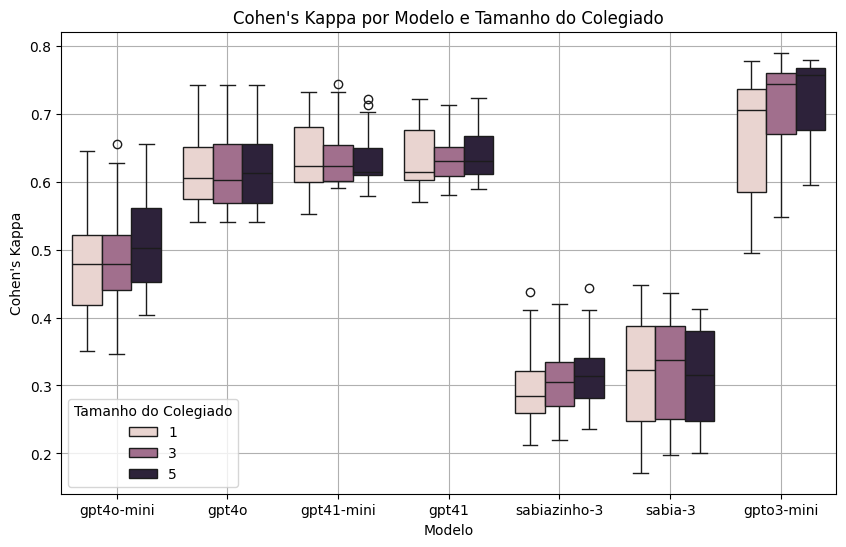

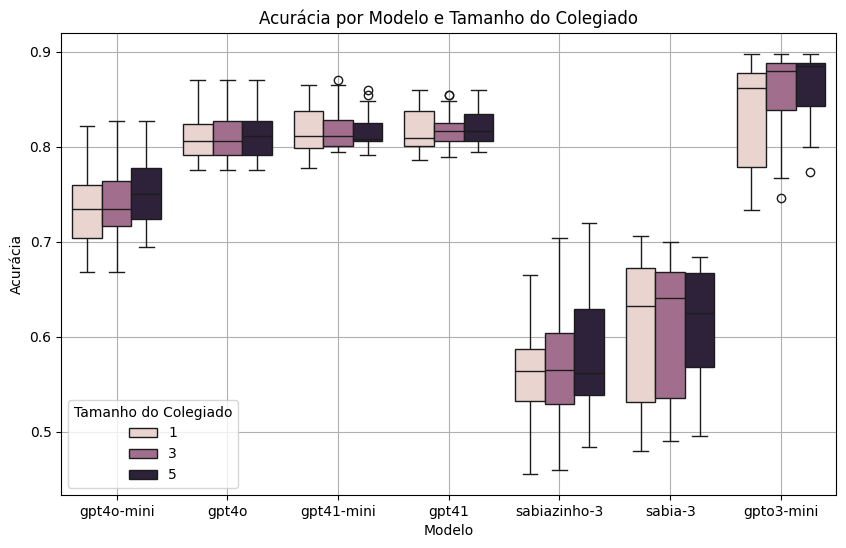

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot do Kappa de Cohen
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_resultados_colegiado, x='model', y='cohen_kappa', hue='colegiado')
plt.title("Cohen's Kappa por Modelo e Tamanho do Colegiado")
plt.xlabel("Modelo")
plt.ylabel("Cohen's Kappa")
plt.legend(title='Tamanho do Colegiado')
plt.grid()
plt.show()

# Boxplot da Acurácia
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_resultados_colegiado, x='model', y='accuracy', hue='colegiado')
plt.title("Acurácia por Modelo e Tamanho do Colegiado")
plt.xlabel("Modelo")
plt.ylabel("Acurácia")
plt.legend(title='Tamanho do Colegiado')
plt.grid()
plt.show()


In [ ]:
df_model_answers2

,model,experiment,judge,exam,area,number,parte,evaluation,score
0,gpt4o-mini,0,0,41,administrativo,1,I,1,0.1
1,gpt4o-mini,0,0,41,administrativo,2,I,1,0.1
2,gpt4o-mini,0,0,41,administrativo,3,I,1,0.1
3,gpt4o-mini,0,0,41,administrativo,4,I,1,0.1
4,gpt4o-mini,0,0,41,administrativo,5,I,1,0.1
...,...,...,...,...,...,...,...,...,...
197452,gpto3-mini,9,4,39,trabalhista,13,II,0,0.1
197453,gpto3-mini,9,4,39,trabalhista,14,I,0,0.1
197454,gpto3-mini,9,4,39,trabalhista,15,I,0,0.1
197455,gpto3-mini,9,4,39,trabalhista,16,I,0,0.1
